In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.dates as mdates
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_numeric_dtype
from sklearn.linear_model import LinearRegression
from pprint import pprint
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

1. Research Question
    - Can we predict the S&P price over the next 10 days using financial indicators?
2. Hypothesis
    - Null: A linear regression model trained on windowed data has no correlation to the future price of S&P 500
    - Alternative: A linear regression model predicts the future price of S&P 500 from historical movement patterns

3. Dataset
   - Each column(feature) was collected independently from websites like investing.com and yahoo-finance
   - Then the features were combined manually with standardized date time
   - Some features are given an extra feature that is the natural log of the value, since they originally grow exponentially, and we want a linear relationship to fit a linear model

In [2]:
bond_yield_df = pd.read_csv("Bond yield.csv")
cpi_df = pd.read_csv("Consumer price index.csv")
dj_df = pd.read_csv("Dow Jones.csv")
usd_eur_df = pd.read_csv("USD_EUR.csv")
usd_jpy_df = pd.read_csv("USD_JPY.csv")
gdp_df = pd.read_csv("GDP.csv")
national_hpi_df = pd.read_csv("National home price index.csv")
sp_df = pd.read_csv("S&P Price.csv")

dfs = [bond_yield_df, cpi_df, dj_df, usd_eur_df, usd_jpy_df, gdp_df, national_hpi_df, sp_df]

In [3]:
for i in range(len(dfs)):
    dfs[i].columns.values[0] = 'date'
    dfs[i] = dfs[i].drop_duplicates(subset="date", keep="first") 
    dfs[i].set_index('date', inplace=True)
    dfs[i].index = pd.to_datetime(dfs[i].index, errors="coerce").normalize()
    dfs[i] = dfs[i][~dfs[i].index.duplicated(keep="first")]

In [4]:
merged_df = pd.concat(dfs, axis=1)

4. Data Preprocessing
   - Since we had a variety of data collection (daily, weekly, monthly and quarterly), we used ffill() to fill missing values.
   - We removed weekends since the market is closed and could affect the movement of the model/prediction.
   - After looking at the dataset, we decided to use data after 1987, since that was when all features were present
   - Percentage of Nan in each column is listed below.
   - Calculated centered-moving average for S&P price to see a broader trend

In [5]:
df = merged_df[['Value', 'DJIA', 'GDP', 'DGS10', 'CSUSHPINSA', 'CPIAUCSL', 'EURO', 'JPY']]
df.columns = ['SP_price','dow_jones','gdp','bond_yield','home_price_index','consumer_price_index','eur','jpy']
df.reset_index(inplace=True)
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
df.set_index("date", inplace=True) 
df = df.reindex(full_date_range)
df.index.name = "date"
nan_counts = df.isna().mean() * 100
print('Nan value Percentage for each column')
print(nan_counts)
df= df.ffill()

df = df[df.index >= '1987-01-01']


Nan value Percentage for each column
SP_price                31.231366
dow_jones               62.381167
gdp                     99.122462
bond_yield              55.591495
home_price_index        98.717444
consumer_price_index    97.361760
eur                     67.618271
jpy                     60.654216
dtype: float64


In [6]:
def insert_mirrored_rows(df, num_rows=30):
    """
    Insert chronologically mirrored data point at head and tail of df
    """
    df = df.copy()
    mirrored_rows_head = df.iloc[:num_rows].copy()
    mirrored_rows_head = mirrored_rows_head.iloc[::-1].reset_index(drop=True)

    mirrored_rows_tail = df.iloc[-num_rows:].copy()
    mirrored_rows_tail = mirrored_rows_tail.iloc[::-1].reset_index(drop=True)

    df_extended = pd.concat([mirrored_rows_head, df, mirrored_rows_tail], ignore_index=True)
    
    return df_extended

In [7]:
extended_df = insert_mirrored_rows(df['SP_price'].copy(), 200)
ma30_df = df.rolling(window=30).mean().reset_index().iloc[30:-30].reset_index(drop=True)
ma100_df = df.rolling(window=100).mean().reset_index().iloc[100:-100].reset_index(drop=True)
ma200_df = df.rolling(window=200).mean().reset_index().iloc[200:-200].reset_index(drop=True)
df['SP_MA_30'] = df['SP_price'].rolling(window=30).mean()
df['SP_MA_100'] = df['SP_price'].rolling(window=100).mean()
df['SP_MA_200'] = df['SP_price'].rolling(window=200).mean()

df['SP_price_ln'] = np.log(df['SP_price'])
df['dow_jones_ln'] = np.log(df['dow_jones'])
df['gdp_ln'] = np.log(df['gdp'])
df['home_price_index_ln'] = np.log(df['home_price_index'])
df['bond_yield_ln'] = np.log(df['bond_yield'])


In [8]:
df.reset_index(inplace=True)

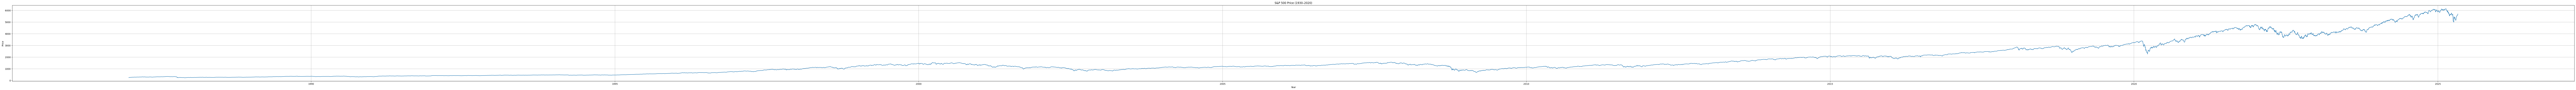

In [9]:
plt.figure(figsize=(200, 6))
plt.plot(df['date'], df['SP_price'])
plt.title('S&P 500 Price (1930–2020)')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)
plt.show()

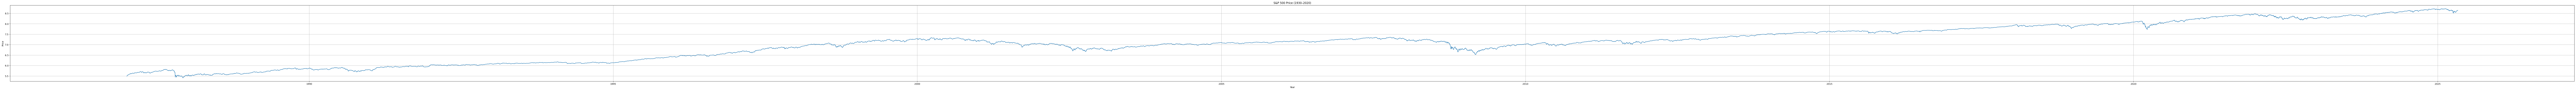

In [10]:
plt.figure(figsize=(200, 6))
plt.plot(df['date'], df['SP_price_ln'])
plt.title('S&P 500 Price (1930–2020)')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)
plt.show()

### Features we used are listed below

In [11]:
daily_features = ["SP_price_ln", "dow_jones_ln", "gdp_ln", "eur", "jpy", "home_price_index_ln", "consumer_price_index", "bond_yield_ln"]

# Change predictive range from here
#################
lookback = 60
forecast = 15
#################
new_cols = {}

for f in daily_features:
    new_cols[f + f"+{forecast}"] = df[f].shift(-forecast)

for f in daily_features:
    for i in range(1, lookback + 1):
        new_cols[f + f"-{i}"] = df[f].shift(i)

df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)

df_with_wknd = df.copy()
df = df[df['date'].dt.weekday < 5].reset_index(drop=True)
# i = 1
# for col in df.columns:
#     print(i, col)
#     i+=1
print(df.shape)
df.head(5)

(10002, 505)


,date,SP_price,dow_jones,gdp,bond_yield,home_price_index,consumer_price_index,eur,jpy,SP_MA_30,...,bond_yield_ln-51,bond_yield_ln-52,bond_yield_ln-53,bond_yield_ln-54,bond_yield_ln-55,bond_yield_ln-56,bond_yield_ln-57,bond_yield_ln-58,bond_yield_ln-59,bond_yield_ln-60
0,1987-01-01,242.712498,1895.95,4722.156,7.23,63.733,111.4,0.9107,157.47,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1987-01-02,244.309998,1927.31,4722.156,7.18,63.733,111.4,0.9084,158.02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1987-01-05,249.415001,1971.32,4722.156,7.08,63.733,111.4,0.9149,159.13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1987-01-06,252.777500,1974.83,4722.156,7.08,63.733,111.4,0.9107,158.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1987-01-07,254.119999,1993.95,4722.156,7.05,63.733,111.4,0.9162,157.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


5. Data Analysis
    - We implemented a 2 level linear regression model.
    - Level 1 fits all features and selects which features have the highest correlation.
    - Level 2 uses those high-correlated features to make a more accurate prediction.
        - Values are first normalized for equal weights between the features.
        - We used adjusted R^2 as our optimization function, then use that to find which features have the highest R^2
        - Select the features (Greedy model). For each features, the model only keeps it if the addition of the feature improves the R^2


In [12]:
# level 1
df_filtered = df[(df['date'].dt.year >= 1980) & (df['date'].dt.year <= 2020)]
col =  df.iloc[:, 26:].columns
df_filtered = df_filtered.dropna(subset=col)
X = df_filtered[col]
y = df_filtered[f'SP_price_ln+{forecast}']

model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)


In [13]:
refined = []
for i in range(len(col)):
    if abs(model.coef_[i]) > 0.1:
        refined.append(col[i])

In [14]:
df_model2 = df[(df['date'].dt.year >= 1980) & (df['date'].dt.year <= 2020)]
features = df.iloc[:, 26:]

scaler_global = StandardScaler()
scaled_array = scaler_global.fit_transform(features)
normalized_all = pd.DataFrame(scaled_array, index=features.index, columns=features.columns)

n = len(normalized_all)

def adj_r2(R2, p):
    return 1 - (1 - R2) * (n - 1) / (n - p - 1)

# Your target columns
target_columns = [
    "SP_price_ln",
    # "dow_jones_ln",
    "eur",
    "jpy",
    "consumer_price_index",
    "bond_yield_ln"
    # "gdp_ln"
]

models = {}

for y_col in target_columns:
    print(f"\n=== Building model for: {y_col} ===")
    y = df_model2[y_col]
    normalized = normalized_all.copy()
    normalized[y_col] = y

    mod_scores = []
    for c in normalized.columns:
        if c == y_col:
            continue
        model = LinearRegression(fit_intercept=True)
        working_df = normalized.dropna(subset=[y_col, c])
        col = working_df[c].to_numpy().reshape(-1, 1)
        model.fit(col, working_df[y_col])
        score = adj_r2(model.score(col, working_df[y_col]), 1)
        mod_scores.append((c, score))

    mod_scores = sorted(mod_scores, key=lambda x: x[1], reverse=True)

    best_score = 0
    selected_cols = []
    reg = LinearRegression(fit_intercept=True)

    for c, _ in mod_scores:
        working_df = normalized.dropna(subset=selected_cols + [c, y_col])
        X = working_df[selected_cols + [c]]
        reg.fit(X, working_df[y_col])
        score = adj_r2(reg.score(X, working_df[y_col]), len(selected_cols) + 1)
        if score > best_score:
            best_score = score
            selected_cols += [c]

    # Final fit with scaler
    final_scaler = StandardScaler()
    working_df = df_model2.dropna(subset=selected_cols + [y_col])
    X_raw = working_df[selected_cols]
    X_scaled = pd.DataFrame(final_scaler.fit_transform(X_raw), columns=selected_cols)
    X_scaled.index = working_df.index
    reg.fit(X_scaled, working_df[y_col])

    # Statsmodels OLS summary
    X_scaled_with_const = sm.add_constant(X_scaled)
    sm_model = sm.OLS(working_df[y_col], X_scaled_with_const).fit()
    print(sm_model.summary())

    # Save everything
    models[y_col] = {
        'features': selected_cols,
        'scaler': final_scaler,
        'reg': reg,
        'sm_model': sm_model
    }



=== Building model for: SP_price_ln ===
                            OLS Regression Results                            
Dep. Variable:            SP_price_ln   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.302e+06
Date:                Mon, 05 May 2025   Prob (F-statistic):               0.00
Time:                        13:22:41   Log-Likelihood:                 30747.
No. Observations:                8858   AIC:                        -6.138e+04
Df Residuals:                    8800   BIC:                        -6.097e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [15]:
# # level 2
# df_model2 = df[(df['date'].dt.year >= 1980) & (df['date'].dt.year <= 2020)]
# normalized = df_model2.copy()
# scaler = StandardScaler()
# SP_y_col = "SP_price_ln"
# DJ_y_col = "dow_jones_ln"
# GDP_y_col = "gdp_ln"
# EUR_y_col = "eur"
# JPY_y_col = "jpy"
# HPI_y_col = "home_price_index_ln"
# CPI_y_col = "consumer_price_index"
# BY_y_col = "bond_yield_ln"

# features = df.iloc[:, 26:]
# y = df_model2[y_col]

# scaled_array = scaler.fit_transform(features)
# normalized = pd.DataFrame(scaled_array, index=features.index, columns=features.columns)
# normalized[y_col] = y

# n = len(normalized)
# def adj_r2(R2, p):
#     return 1 - (1-R2) * (n-1) / (n-p-1)

# mod_2_scores = []
# for c in normalized.columns:
#     if c == y_col: continue
#     model = LinearRegression(fit_intercept=True)
#     working_df = normalized.dropna(subset=[y_col, c])
#     col = working_df[c].to_numpy().reshape(-1, 1)
#     model.fit(col, working_df[y_col])
#     score = adj_r2(model.score(col, working_df[y_col]), 1)
#     mod_2_scores.append((c, score))

# mod_2_scores = sorted(mod_2_scores, key=lambda x: x[1], reverse=True)

# mod_2_score = 0
# mod_2_cols = []
# reg2 = LinearRegression(fit_intercept=True)
# for c, _ in mod_2_scores:
#     working_df = normalized.dropna(subset=mod_2_cols + [c, y_col])
#     X = working_df[mod_2_cols + [c]]
#     reg2.fit(X, working_df[y_col])
#     score = adj_r2(reg2.score(X, working_df[y_col]), len(mod_2_cols) + 1)
#     if score > mod_2_score:
#         mod_2_score = score
#         mod_2_cols += [c]

# final_scaler = StandardScaler()
# working_df = df_model2.dropna(subset=mod_2_cols + [y_col])
# X2_raw = working_df[mod_2_cols]
# X2_scaled = pd.DataFrame(final_scaler.fit_transform(X2_raw), columns=mod_2_cols)
# X2_scaled.index = working_df.index

# reg2.fit(X2_scaled, working_df[y_col])

# X2_scaled_with_const = sm.add_constant(X2_scaled)
# model_sm_final = sm.OLS(working_df[y_col], X2_scaled_with_const).fit()

# print(model_sm_final.summary())

6. Modeling, Testing and Visualization
   - Below is a method that tests a specific date and pprojects the prediction onto a graph along with the actual data
   - The method creates a price prediction for each of the prediction range (day 1 to 15), and graphs it to show a continous prediction

In [16]:
def plot_predictions(selected_date, window=30):
    selected_date = pd.to_datetime(selected_date)
    selected_idx = df[df['date'] == selected_date].index[0]

    predicted_series = {target: [] for target in models.keys()}
    predicted_dates = []

    current_row = df.iloc[selected_idx].copy()

    for step in range(forecast):
        idx = selected_idx + step
        predicted_dates.append(df['date'].iloc[idx])

        # Iterate over each model to predict and update
        for target_var, model_data in models.items():
            features = model_data['features']
            scaler = model_data['scaler']
            reg = model_data['reg']

            # Prepare features for prediction
            X_features = current_row[features]
            X_scaled = pd.DataFrame(scaler.transform(X_features.to_frame().T), columns=features)

            pred_ln = reg.predict(X_scaled)[0]
            predicted_series[target_var].append(pred_ln)

            # Find lagged columns for this target (e.g., SP_price_ln_t-1)
            lagged_cols = [col for col in features if target_var in col]
            if lagged_cols:
                shifted_vals = current_row[lagged_cols].copy()
                shifted_vals = [pred_ln] + list(shifted_vals.values[:-1])
                current_row[lagged_cols] = shifted_vals

        # No need to handle valid_indices if dates are aligned

    # Plot SP500 as the main example
    plot_start = selected_idx - window
    plot_end = selected_idx + forecast + window

    plt.figure(figsize=(16, 6))
    plt.plot(df.index[plot_start:plot_end], df['SP_price'].iloc[plot_start:plot_end],
             label='Actual SP500', linewidth=4, color='blue')
    plt.plot(range(selected_idx, selected_idx + forecast),
             np.exp(predicted_series['SP_price_ln']), 'ro--',
             label=f'Iterative SP500 prediction ({forecast} days)', linewidth=3, markersize=8)

    plt.axvline(x=selected_idx, color='green', linewidth=3)

    xticks = df.index[plot_start:plot_end:5]
    xlabels = df['date'].iloc[plot_start:plot_end:5].dt.strftime('%Y-%m-%d')
    plt.xticks(ticks=xticks, labels=xlabels, rotation=45)

    plt.title(f"Iterative {forecast}-day prediction from {selected_date.date()}")
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.legend()
    plt.show()

    # Error metric for SP500
    actual_prices = df['SP_price'].iloc[selected_idx:selected_idx + forecast].values
    predicted_prices = np.array(predicted_series['SP_price_ln']).flatten()

    mse = mean_squared_error(actual_prices, predicted_prices)
    rmse = np.sqrt(mse)
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')

    # Optional: print other series' last predicted values
    for target_var, preds in predicted_series.items():
        print(f"Last predicted {target_var}: {preds[-1]}")


In [17]:
# def plot_predictions(selected_date, window = 30):
#     selected_date = pd.to_datetime(selected_date)
#     selected_idx = df[df['date'] == selected_date].index[0]

#     predicted_prices = []
#     predicted_dates = []
#     valid_indices = []

#     current_row = df.iloc[selected_idx].copy()
    
#     for step in range(forecast):
#         idx = selected_idx + step
#         X_features = current_row[mod_2_cols]
#         X_scaled = pd.DataFrame(final_scaler.transform(X_features.to_frame().T), columns=mod_2_cols)

#         pred_ln = reg2.predict(X_scaled)[0]
#         print(pred_ln)
#         pred_price = (pred_ln)

#         predicted_prices.append(pred_price)
#         predicted_dates.append(df['date'].iloc[selected_idx + step])

#         sp_cols = [col for col in mod_2_cols if 'SP_price_ln' in col]
#         shifted_sp = current_row[sp_cols].copy()

#         shifted_sp_values = [pred_price] + list(shifted_sp.values[:-1])

#         current_row[sp_cols] = shifted_sp_values
#         valid_indices.append(idx)


#     plot_start = selected_idx - window
#     plot_end = selected_idx + forecast + window

#     plt.figure(figsize=(16, 6))
    
#     plt.plot(df.index[plot_start:plot_end], df['SP_price'].iloc[plot_start:plot_end], label='Actual price', linewidth=4, color='blue')
#     plt.plot(valid_indices, np.exp(predicted_prices), 'ro--', label=f'Iterative prediction ({forecast} days)', linewidth=3, markersize=8)
#     plt.axvline(x=selected_idx, color='green', linewidth=3)

#     xticks = df.index[plot_start:plot_end:5]
#     xlabels = df['date'].iloc[plot_start:plot_end:5].dt.strftime('%Y-%m-%d')
#     plt.xticks(ticks=xticks, labels=xlabels, rotation=45)
    
#     plt.title(f"Iterative {forecast}-day prediction from {selected_date.date()}")
#     plt.xlabel('Date')
#     plt.ylabel('S&P 500 Price')
#     plt.legend()
#     plt.show()

#     actual_prices = df['SP_price'].iloc[selected_idx:selected_idx + forecast].values
#     predicted_prices = np.array(predicted_prices).flatten()

#     mse = mean_squared_error(actual_prices, predicted_prices)
#     rmse = np.sqrt(mse)
#     print(f'Mean Squared Error: {mse}')
#     print(f'Root Mean Squared Error: {rmse}')

In [18]:
# def plot_predictions(selected_date, window=30):
#     selected_date = pd.to_datetime(selected_date)
#     selected_idx = df[df['date'] == selected_date].index[0]
    
#     predicted_prices = []
#     valid_indices = []
    
#     for offset in range(forecast):
#         idx = selected_idx + offset
#         X_row = df.iloc[idx]
#         X_features = X_row[mod_2_cols].to_frame().T
#         X_scaled = pd.DataFrame(final_scaler.transform(X_features), columns=mod_2_cols)
#         pred_ln = reg2.predict(X_scaled)[0]
#         pred_price = np.exp(pred_ln)
        
#         predicted_prices.append(pred_price)
#         valid_indices.append(idx)

#     plot_start = selected_idx - window
#     plot_end = selected_idx + forecast + window
    
#     plt.figure(figsize=(16, 6))
    
#     plt.plot(df.index[plot_start:plot_end], df['SP_price'].iloc[plot_start:plot_end], label='Actual price', linewidth=4, color='blue')
#     plt.plot(valid_indices, predicted_prices, 'ro--', label=f'Predicted price for {forecast} days)', linewidth=3, markersize=8)
#     plt.axvline(x=selected_idx, color='green', linewidth=3)
    
#     xticks = df.index[plot_start:plot_end:5]
#     xlabels = df['date'].iloc[plot_start:plot_end:5].dt.strftime('%Y-%m-%d')
#     plt.xticks(ticks=xticks, labels=xlabels, rotation=45)
    
#     plt.title(f"{forecast} days prediction from {selected_date.date()} based on past {lookback} days")
#     plt.xlabel('Date')
#     plt.ylabel('S&P 500 Price')
#     plt.legend()
#     plt.show()
#     actual_prices = df['SP_price'].iloc[selected_idx:selected_idx + forecast].values
#     predicted_prices = np.array(predicted_prices).flatten()
    
#     mse = mean_squared_error(actual_prices, predicted_prices)
#     rmse = np.sqrt(mse)
    
#     print(f'Mean Squared Error: {mse}')
#     print(f'Root Mean Squared Error: {rmse}')

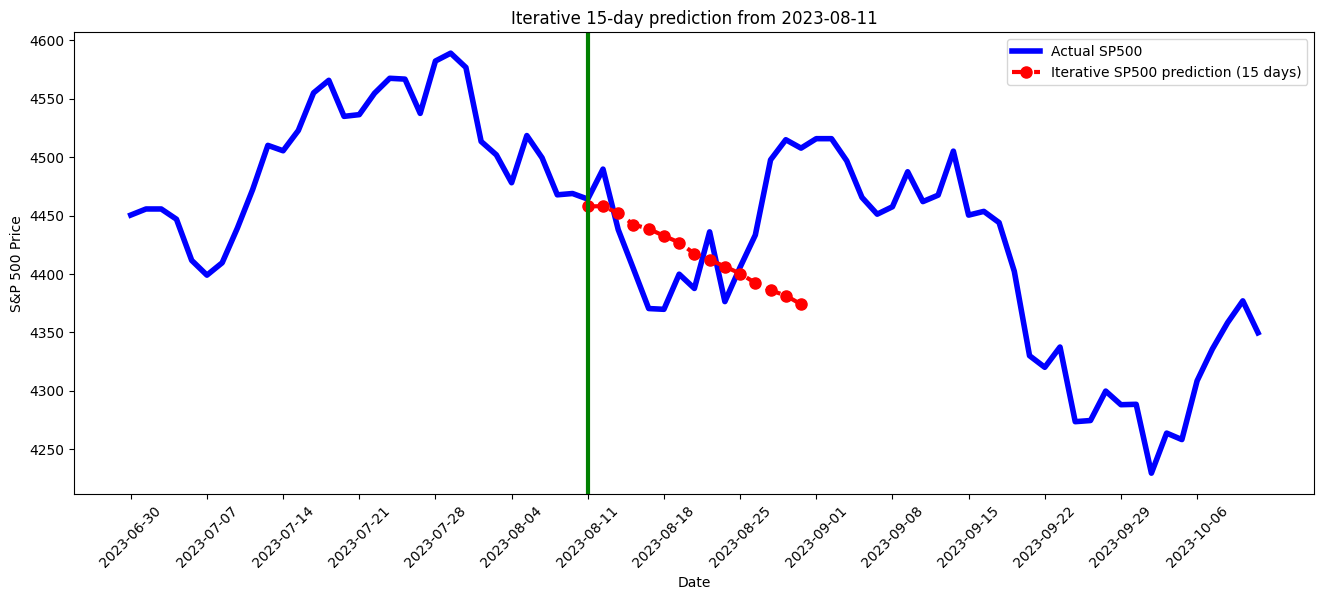

Mean Squared Error: 19579490.531997826
Root Mean Squared Error: 4424.871809668369
Last predicted SP_price_ln: 8.383436597597665
Last predicted eur: 0.9180693010545984
Last predicted jpy: 143.7212815505474
Last predicted consumer_price_index: 306.2525943996057
Last predicted bond_yield_ln: 1.3493019907025623


In [19]:
plot_predictions('2023-8-11')

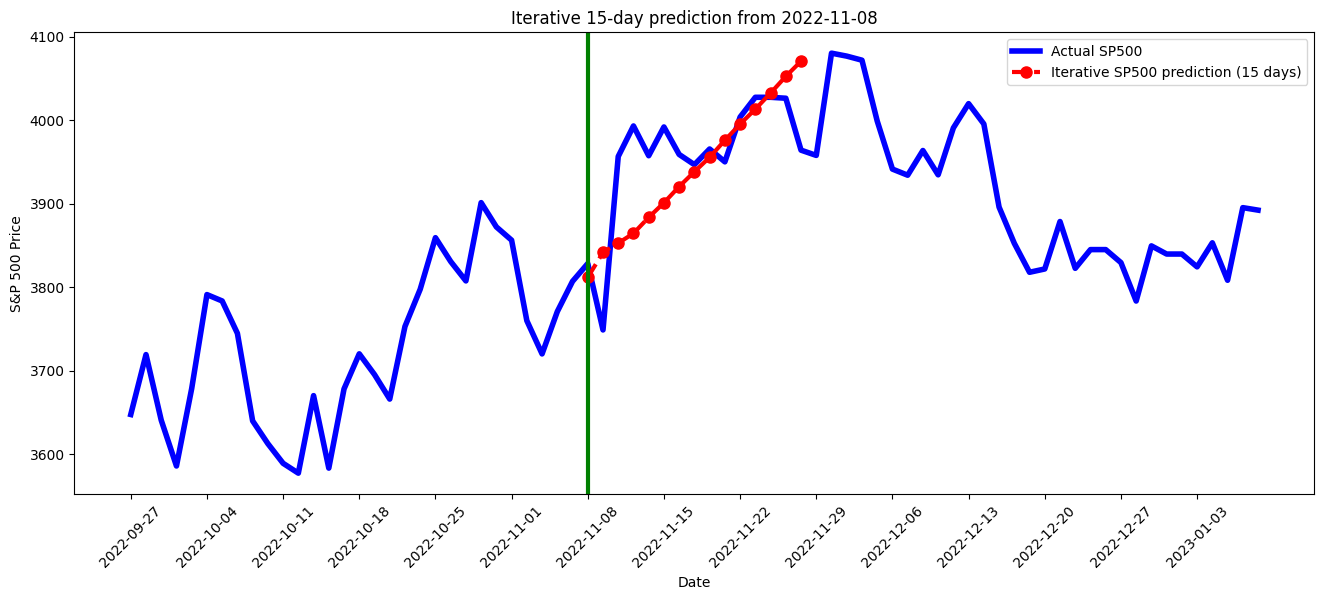

Mean Squared Error: 15591783.906114977
Root Mean Squared Error: 3948.6432994276624
Last predicted SP_price_ln: 8.311533457112565
Last predicted eur: 0.990246403184605
Last predicted jpy: 143.6755740248059
Last predicted consumer_price_index: 298.8042064054823
Last predicted bond_yield_ln: 1.3758111056610447


In [20]:
plot_predictions('2022-11-8')

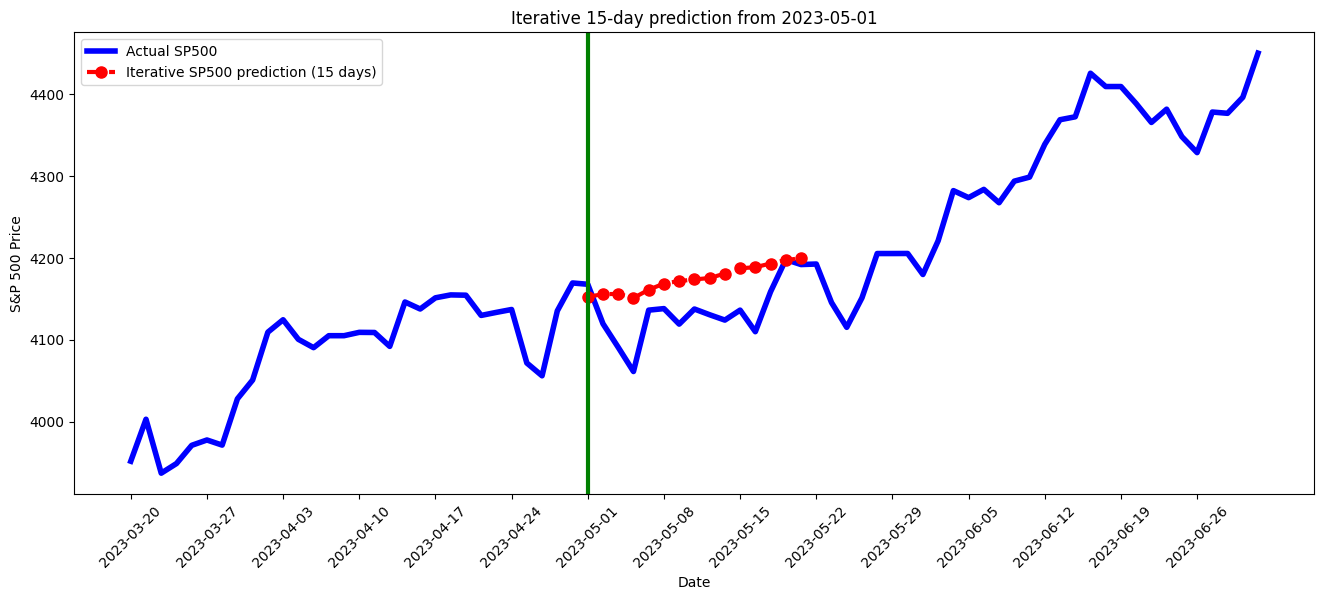

Mean Squared Error: 17027922.590864595
Root Mean Squared Error: 4126.490347845805
Last predicted SP_price_ln: 8.34277676034425
Last predicted eur: 0.9291490249158066
Last predicted jpy: 134.96576475711578
Last predicted consumer_price_index: 302.9664247774029
Last predicted bond_yield_ln: 1.0923054757665818


In [21]:
plot_predictions('2023-5-1')

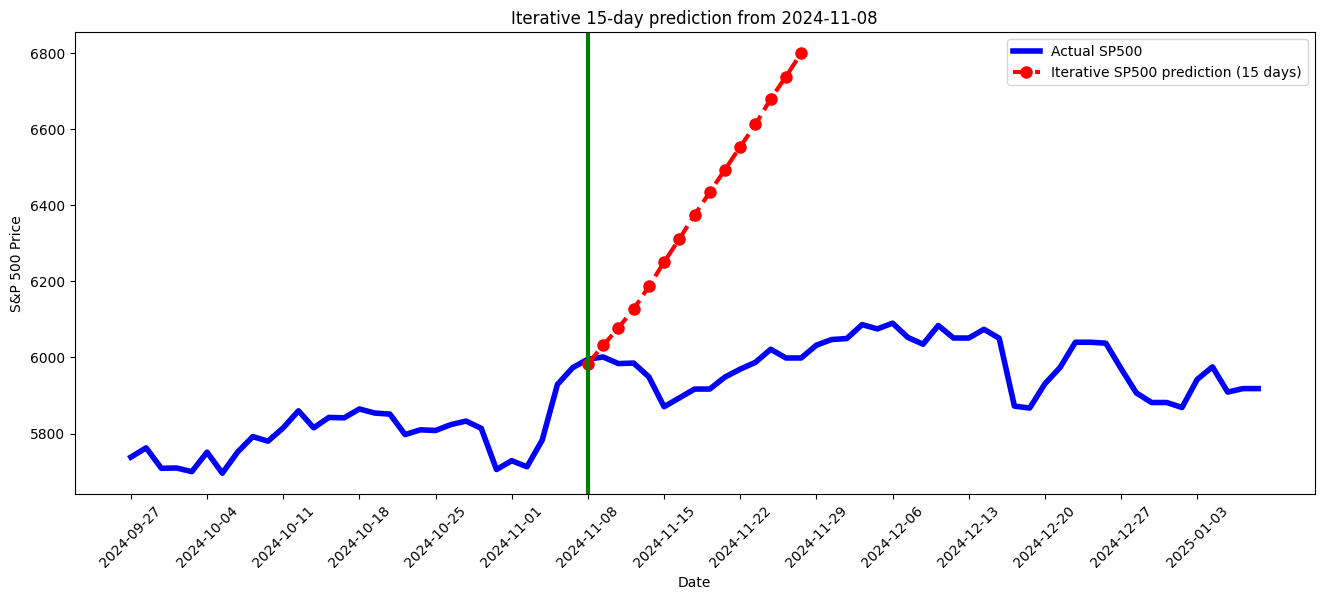

Mean Squared Error: 35449521.43080361
Root Mean Squared Error: 5953.950069559167
Last predicted SP_price_ln: 8.82466606590238
Last predicted eur: 0.9103755957644745
Last predicted jpy: 149.80455306140374
Last predicted consumer_price_index: 316.5953453353495
Last predicted bond_yield_ln: 1.3266429931225034


In [22]:
plot_predictions('2024-11-8')

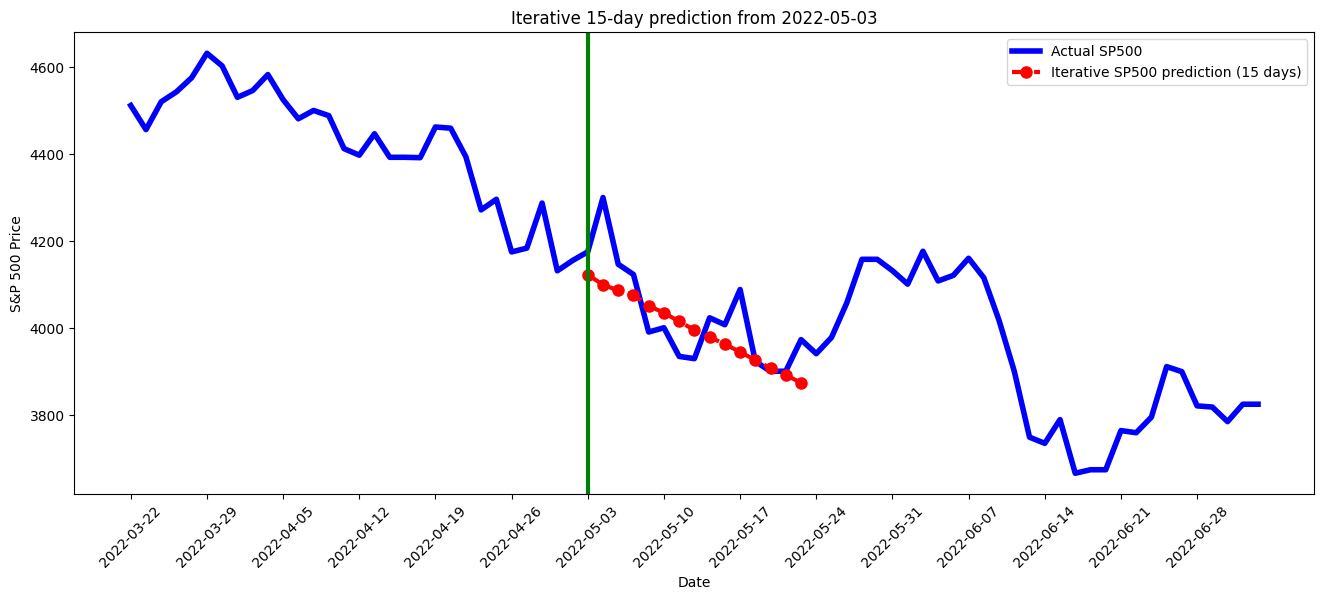

Mean Squared Error: 16172675.081113786
Root Mean Squared Error: 4021.5264615707533
Last predicted SP_price_ln: 8.262095736071638
Last predicted eur: 0.9380214230267059
Last predicted jpy: 129.78413994873787
Last predicted consumer_price_index: 291.52929910876946
Last predicted bond_yield_ln: 1.0671417068458413


In [23]:
plot_predictions('2022-5-3')

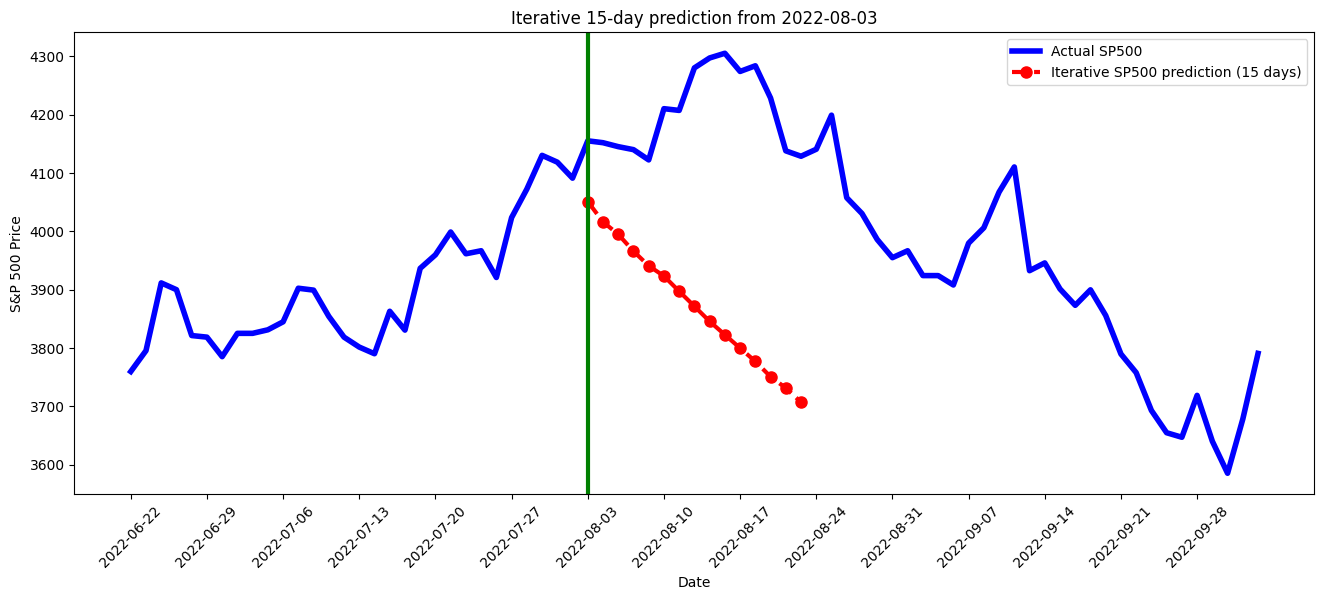

Mean Squared Error: 17612988.174117725
Root Mean Squared Error: 4196.783074465217
Last predicted SP_price_ln: 8.218052341629612
Last predicted eur: 0.980909366844505
Last predicted jpy: 133.85819247451477
Last predicted consumer_price_index: 295.3165204511335
Last predicted bond_yield_ln: 0.9340560950783992


In [41]:
plot_predictions('2022-8-3')

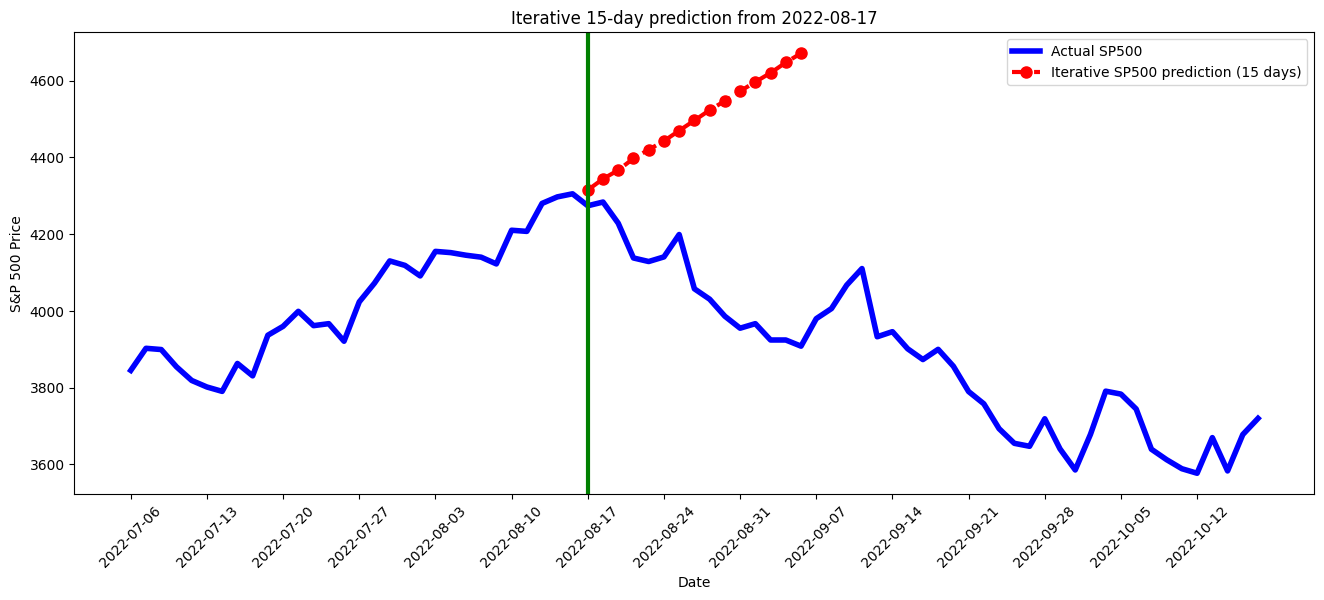

Mean Squared Error: 16564657.390426246
Root Mean Squared Error: 4069.970195274929
Last predicted SP_price_ln: 8.44921852660282
Last predicted eur: 0.9716268958624861
Last predicted jpy: 132.26212751726055
Last predicted consumer_price_index: 295.35411801163855
Last predicted bond_yield_ln: 0.8862109304732041


In [42]:
plot_predictions('2022-8-17')

7. Results Analysis
   - The result accurately captures the broad movement of the 15 day predictive span.
   - Looking at the OLS regression results, the R^2 is extremely high, and Probablity of F-stats is extremely low, indicating that the model is accurate when looked at whole. We concluded to reject H0, and state that the linear regression model is accurate.
   - The measure we tried to implement for each predictive events: MSE and RMSE doesn't accurately measure the accuracy of the model, since the absolute value of the price changes, and when the price is high, MSE goes up even if the prediction is more accurate.
   - For the future, we are looking into taking more historical data into our model, while keeping the number of features on the conservative side: coming up with a way to select which features are effective in the predictive model.
   - Another point is expanding the type of indicators. There are numerous financial indicators specifically made for S&P price, so we want to explore those in the future.

In [24]:
def plot_all_predictions(selected_date, window=30):
    selected_date = pd.to_datetime(selected_date)
    selected_idx = df[df['date'] == selected_date].index[0]

    predicted_series = {target: [] for target in models.keys()}
    predicted_dates = []

    current_row = df.iloc[selected_idx].copy()

    for step in range(forecast):
        idx = selected_idx + step
        predicted_dates.append(df['date'].iloc[idx])

        # Predict each target and update lagged features
        for target_var, model_data in models.items():
            features = model_data['features']
            scaler = model_data['scaler']
            reg = model_data['reg']

            # Prepare features for prediction
            X_features = current_row[features]
            X_scaled = pd.DataFrame(scaler.transform(X_features.to_frame().T), columns=features)

            pred_value = reg.predict(X_scaled)[0]
            predicted_series[target_var].append(pred_value)

            # Update lagged columns
            lagged_cols = [col for col in features if target_var in col]
            if lagged_cols:
                shifted_vals = current_row[lagged_cols].copy()
                shifted_vals = [pred_value] + list(shifted_vals.values[:-1])
                current_row[lagged_cols] = shifted_vals

    # Plotting
    num_targets = len(models)
    fig, axes = plt.subplots(num_targets, 1, figsize=(16, 4 * num_targets), sharex=True)

    if num_targets == 1:
        axes = [axes]  # Make it iterable if only one

    plot_start = selected_idx - window
    plot_end = selected_idx + forecast + window
    x_range = df.index[plot_start:plot_end]
    xticks = df.index[plot_start:plot_end:5]
    xlabels = df['date'].iloc[plot_start:plot_end:5].dt.strftime('%Y-%m-%d')

    for ax, (target_var, preds) in zip(axes, predicted_series.items()):
        # Actual series
        ax.plot(x_range, df[target_var].iloc[plot_start:plot_end],
                label=f'Actual {target_var}', linewidth=2, color='blue')
        
        # Predicted series
        ax.plot(range(selected_idx, selected_idx + forecast), preds,
                'ro--', label=f'Predicted {target_var}', linewidth=2, markersize=5)
        
        ax.axvline(x=selected_idx, color='green', linewidth=2)
        ax.set_title(f'{target_var} prediction')
        ax.legend()
        ax.set_xticks(xticks)
        ax.set_xticklabels(xlabels, rotation=45)

    plt.tight_layout()
    plt.show()


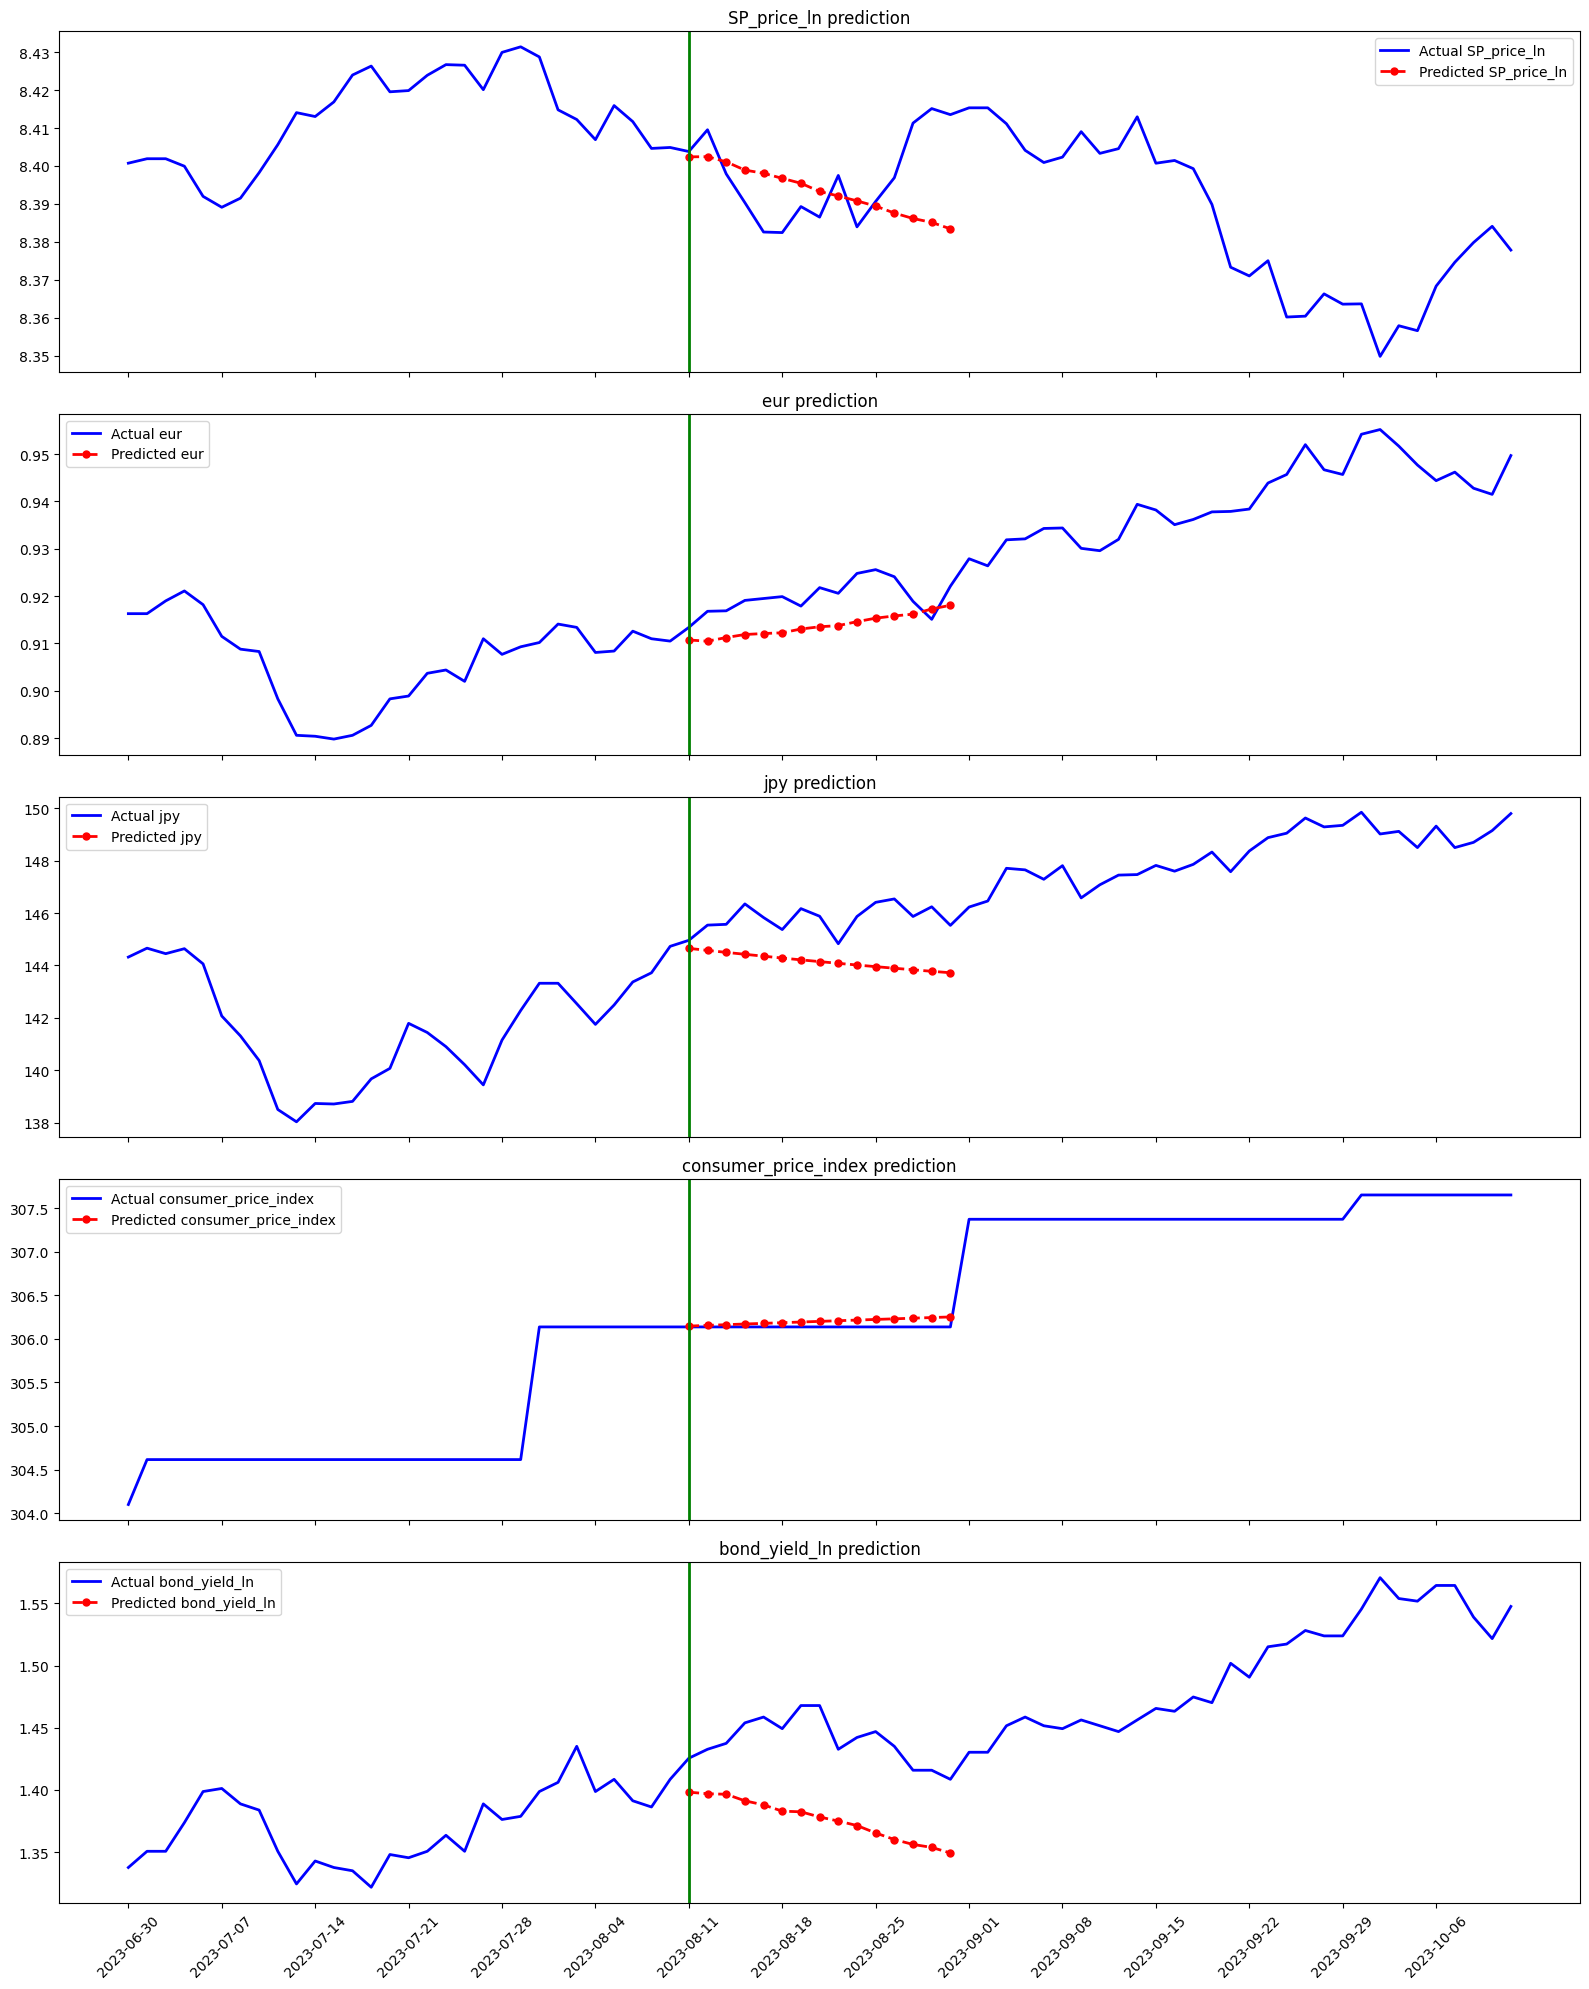

In [25]:
plot_all_predictions('2023-8-11')

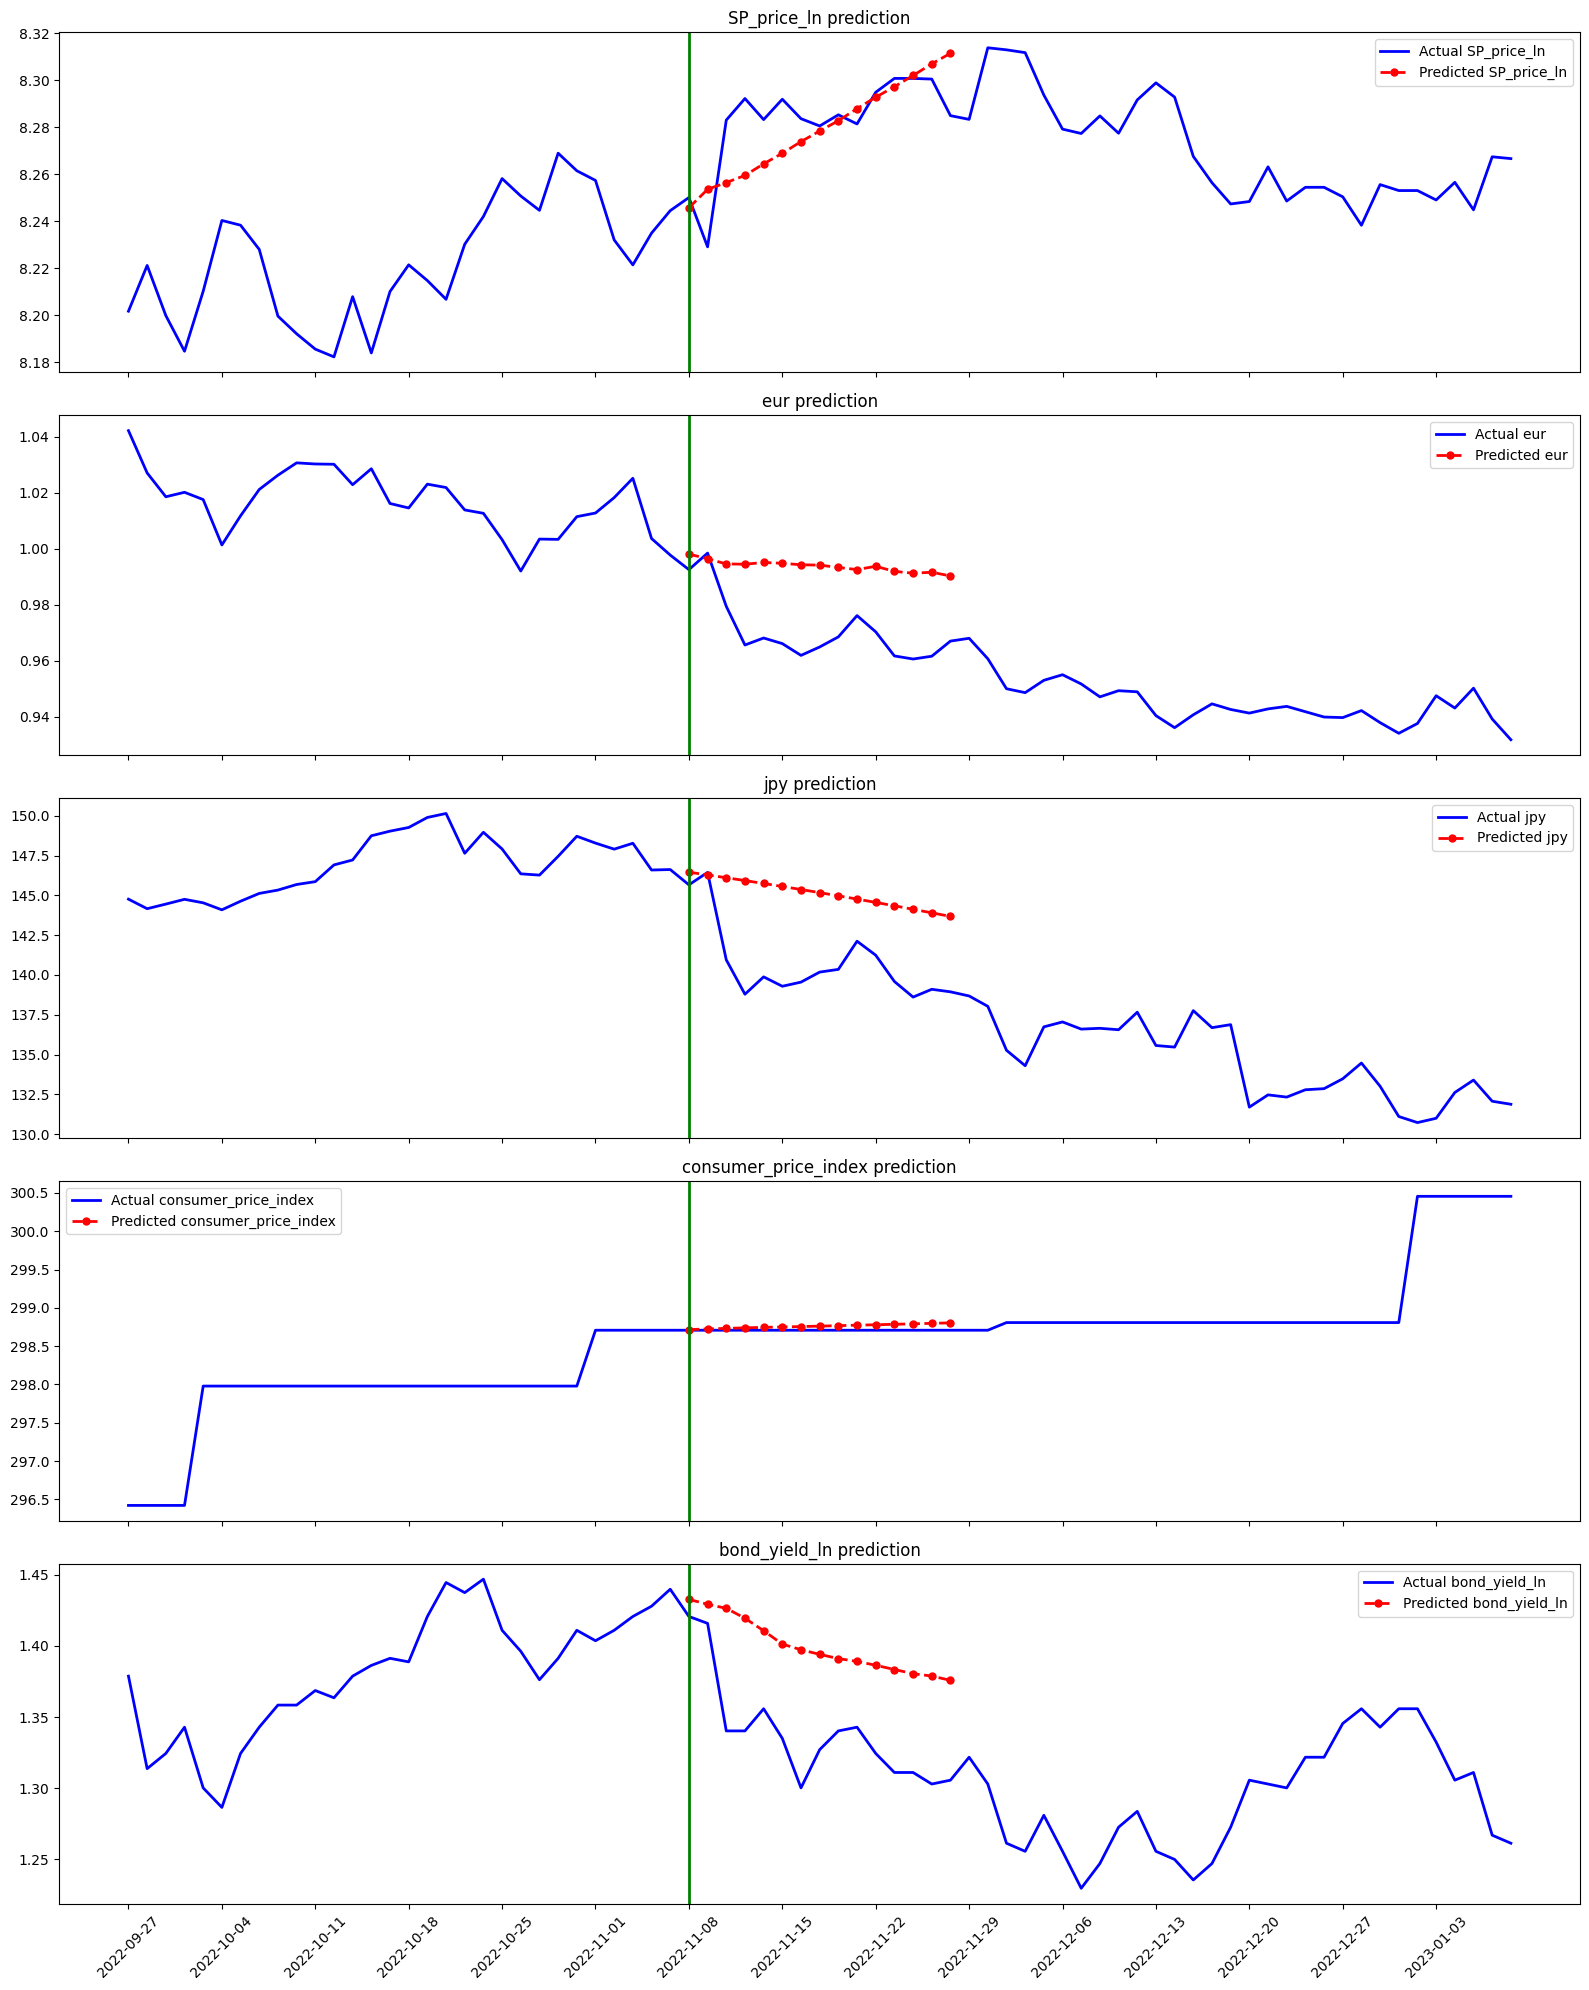

In [26]:
plot_all_predictions('2022-11-8')

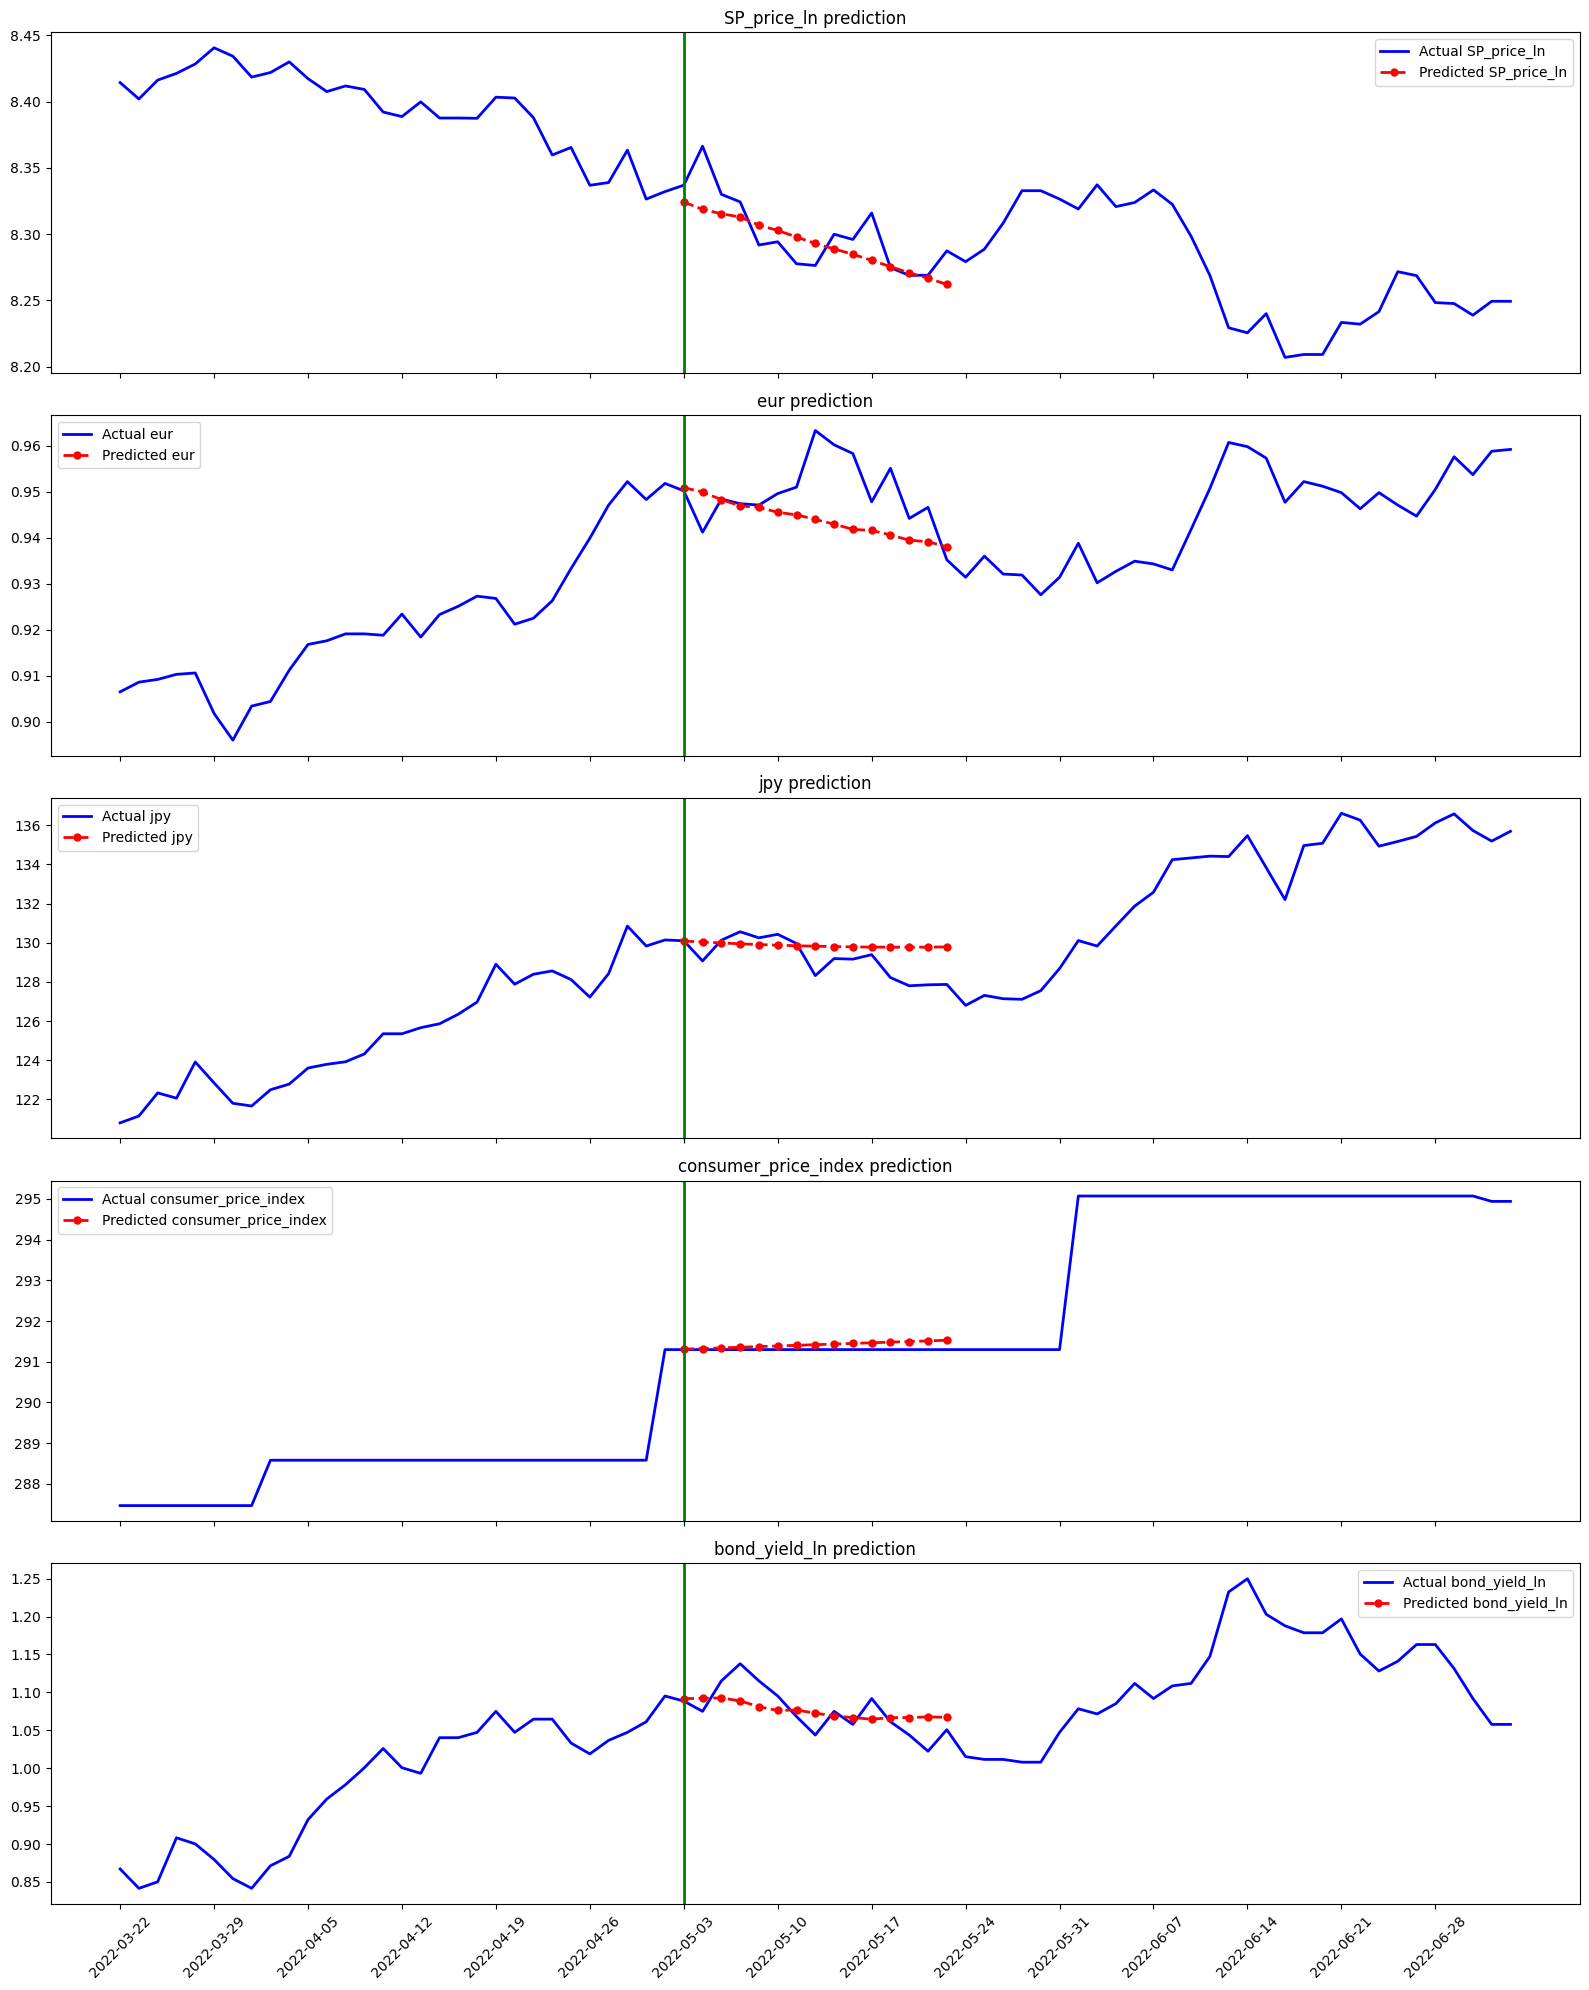

In [27]:
plot_all_predictions('2022-5-3')

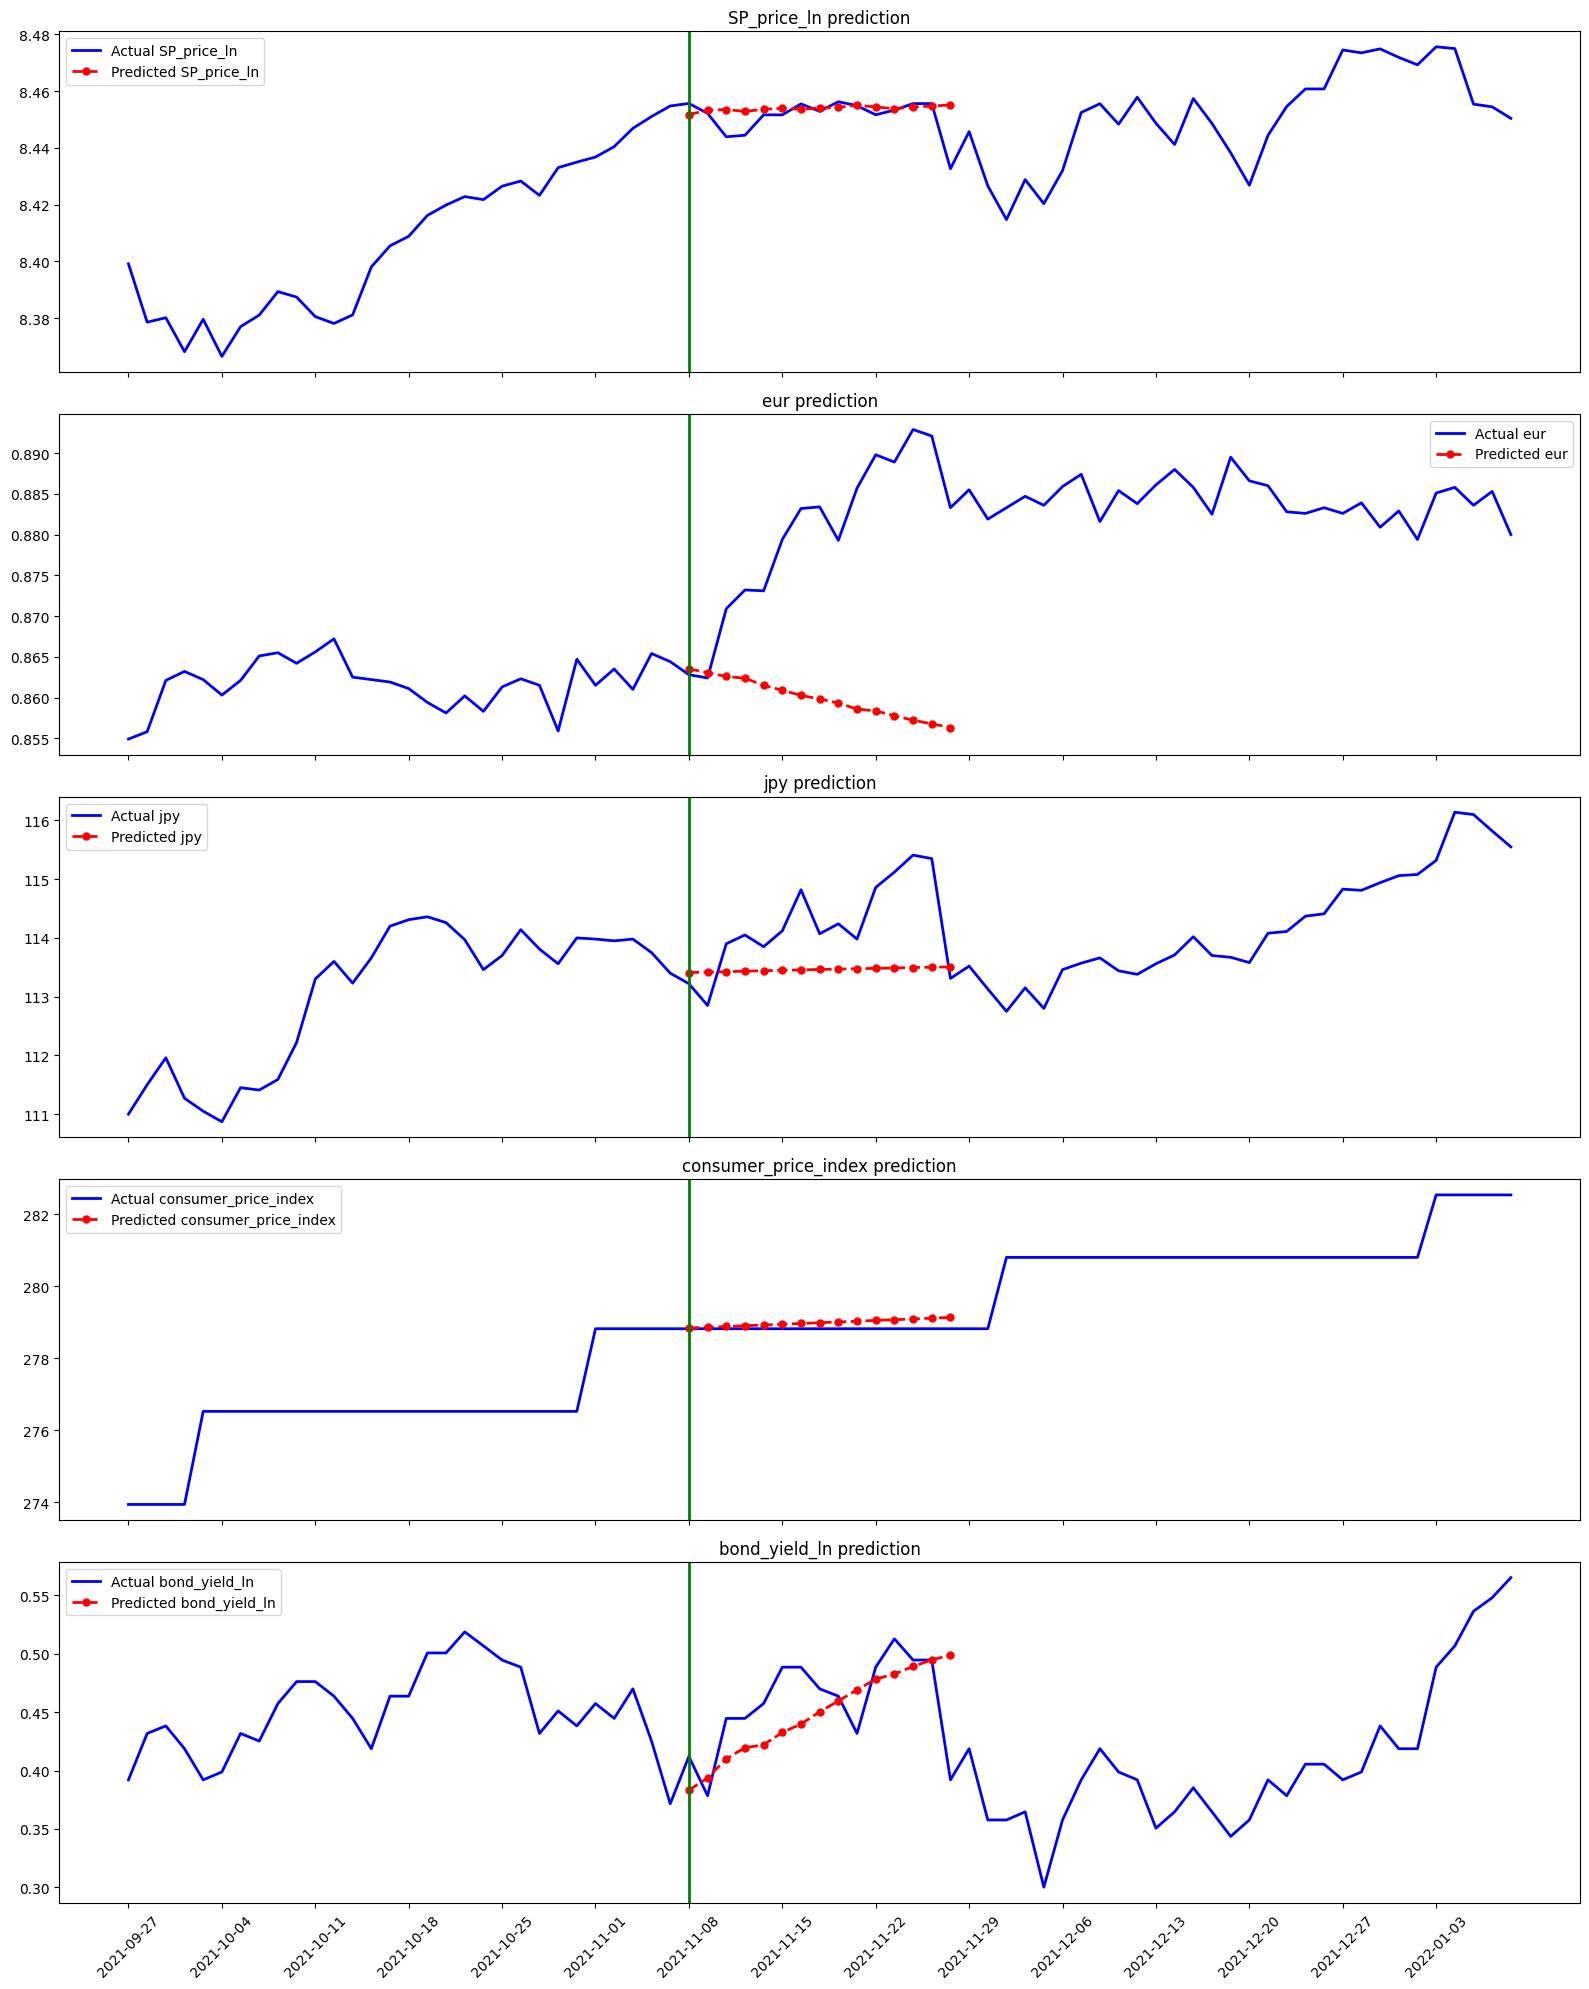

In [35]:
plot_all_predictions('2021-11-8')

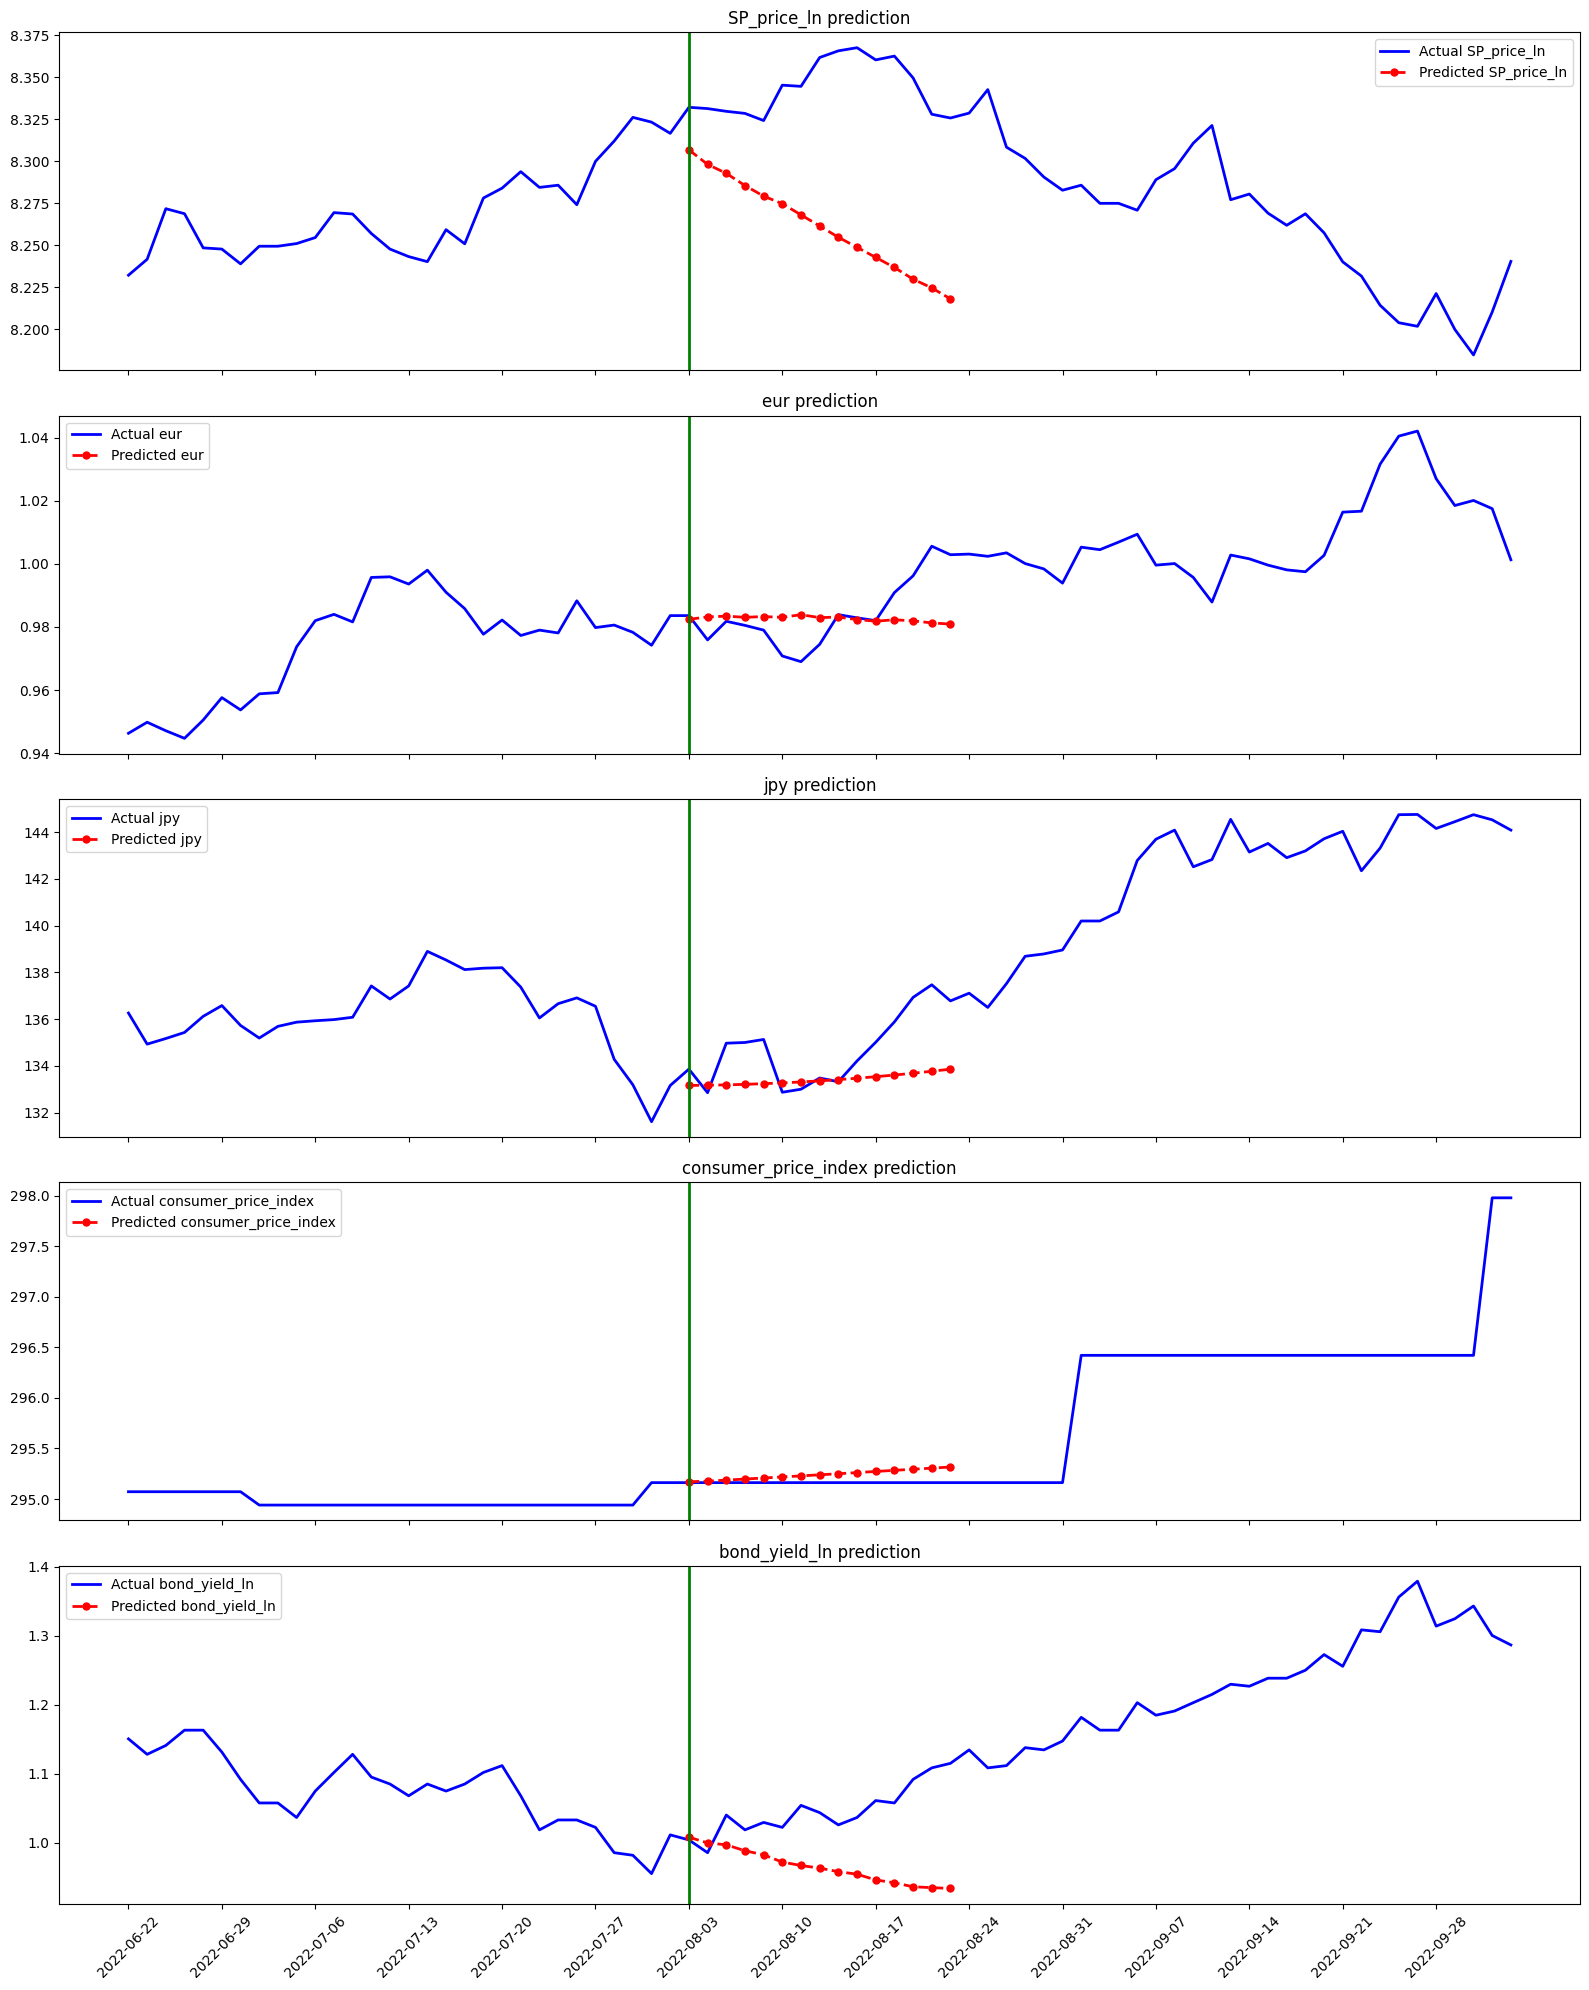

In [37]:
plot_all_predictions('2022-8-3')

In [28]:
# level 3
new_cols = {}
df_model3 = df[(df['date'].dt.year >= 1980) & (df['date'].dt.year <= 2020)]
for i in range(forecast):
    new_cols[f'SP_price_ln+{i}'] = df_model3['SP_price_ln'].shift(-i)
df_model3 = pd.concat([df_model3, pd.DataFrame(new_cols)], axis=1)

normalized = df_model3.copy()
scaler = StandardScaler()
y_col = [f'SP_price_ln+{i}' for i in range(forecast)]

y = df_model3[y_col]

In [29]:
scaled_array = scaler.fit_transform(features)
normalized = pd.DataFrame(scaled_array, index=features.index, columns=features.columns)
normalized[y_col] = y

n = len(normalized)
def adj_r2(R2, p):
    return 1 - (1-R2) * (n-1) / (n-p-1)

mod_3_scores = []
for c in normalized.columns:
    if c in y_col: continue
    model = LinearRegression(fit_intercept=True)
    working_df = normalized.dropna(subset=y_col + [c])
    col = working_df[c].to_numpy().reshape(-1, 1)
    model.fit(col, working_df[y_col])
    score = adj_r2(model.score(col, working_df[y_col]), 1)
    mod_3_scores.append((c, score))

mod_3_scores = sorted(mod_3_scores, key=lambda x: x[1], reverse=True)

mod_3_score = 0
mod_3_cols = []
reg3 = LinearRegression(fit_intercept=True)
for c, _ in mod_3_scores:
    working_df = normalized.dropna(subset=mod_3_cols + y_col + [c])
    X = working_df[mod_3_cols + [c]]
    reg3.fit(X, working_df[y_col])
    score = adj_r2(reg3.score(X, working_df[y_col]), len(mod_3_cols) + 1)
    if score > mod_3_score:
        mod_3_score = score
        mod_3_cols += [c]

final_scaler = StandardScaler()
working_df = df_model3.dropna(subset=mod_3_cols + y_col)
X3_raw = working_df[mod_3_cols]
X3_scaled = pd.DataFrame(final_scaler.fit_transform(X3_raw), columns=mod_3_cols)
X3_scaled.index = working_df.index

reg3.fit(X3_scaled, working_df[y_col])

LinearRegression()

In [30]:
def plot_predictions2(selected_date, window=30):
    selected_date = pd.to_datetime(selected_date)
    selected_idx = df[df['date'] == selected_date].index[0]

    # Extract current feature row and scale it
    current_row = df.iloc[selected_idx]
    X_features = current_row[mod_3_cols].to_frame().T  # shape: (1, n_features)
    X_scaled = pd.DataFrame(final_scaler.transform(X_features), columns=mod_3_cols)

    # Predict the entire window of log prices
    pred_ln_vector = reg3.predict(X_scaled)[0]
    predicted_prices = np.exp(pred_ln_vector)  # Convert log-prices to prices

    # Determine the corresponding future dates
    predicted_dates = df['date'].iloc[selected_idx:selected_idx + forecast].values

    # Plotting
    plot_start = selected_idx - window
    plot_end = selected_idx + forecast + window

    plt.figure(figsize=(16, 6))
    
    plt.plot(df.index[plot_start:plot_end], df['SP_price'].iloc[plot_start:plot_end],
             label='Actual price', linewidth=4, color='blue')
    plt.plot(range(selected_idx, selected_idx + forecast), predicted_prices,
             'ro--', label=f'Vector prediction ({forecast} days)', linewidth=3, markersize=8)
    plt.axvline(x=selected_idx, color='green', linewidth=3)

    xticks = df.index[plot_start:plot_end:5]
    xlabels = df['date'].iloc[plot_start:plot_end:5].dt.strftime('%Y-%m-%d')
    plt.xticks(ticks=xticks, labels=xlabels, rotation=45)
    
    plt.title(f"Vector {forecast}-day prediction from {selected_date.date()}")
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.legend()
    plt.show()

    # Error metrics if possible
    actual_prices = df['SP_price'].iloc[selected_idx:selected_idx + forecast].values
    mse = mean_squared_error(actual_prices, predicted_prices)
    rmse = np.sqrt(mse)
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')

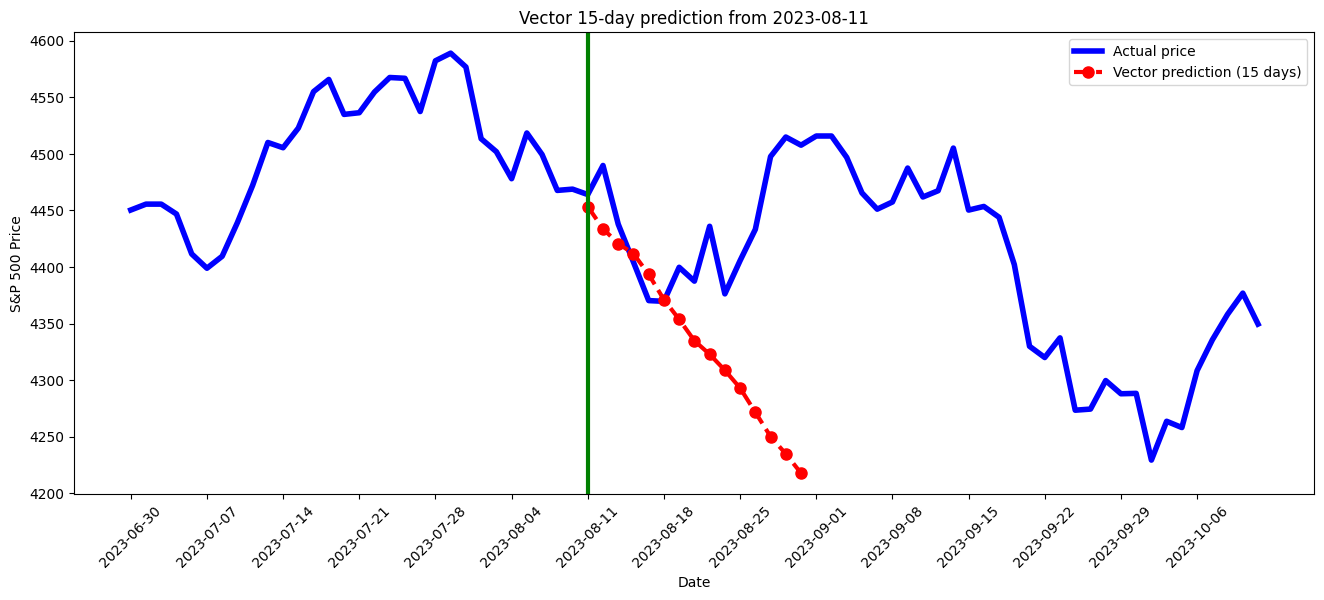

Mean Squared Error: 19246.0264
Root Mean Squared Error: 138.7300


In [31]:
plot_predictions2('2023-8-11')

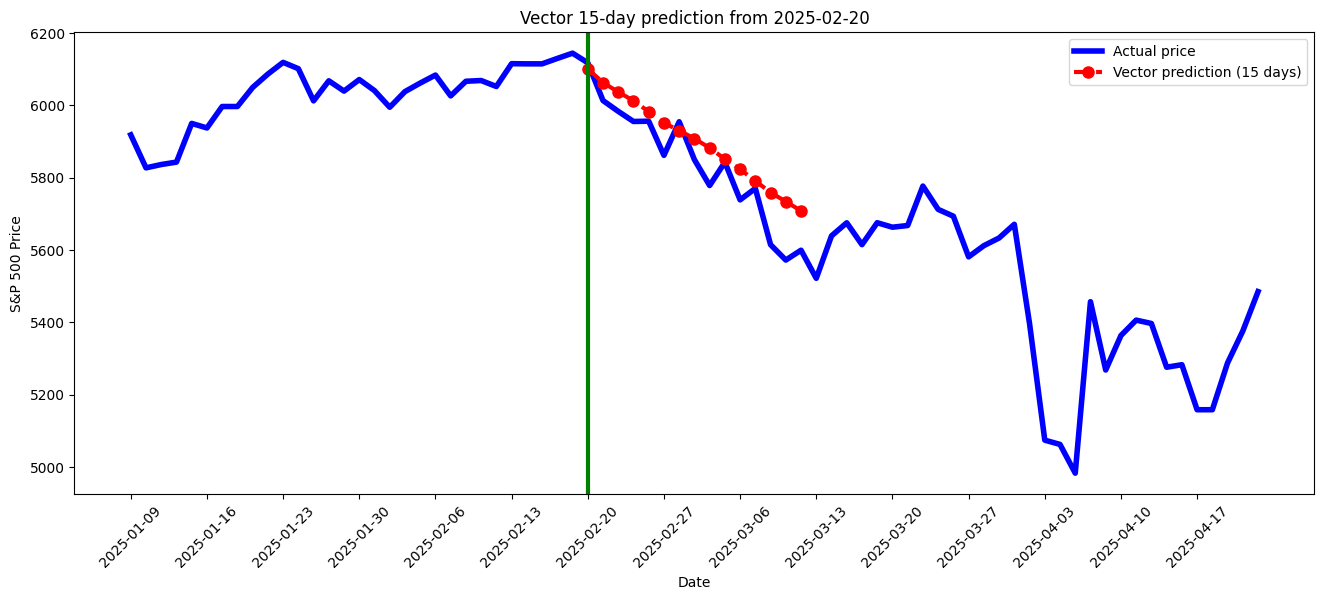

Mean Squared Error: 6601.0913
Root Mean Squared Error: 81.2471


In [32]:
plot_predictions2('2025-2-20')

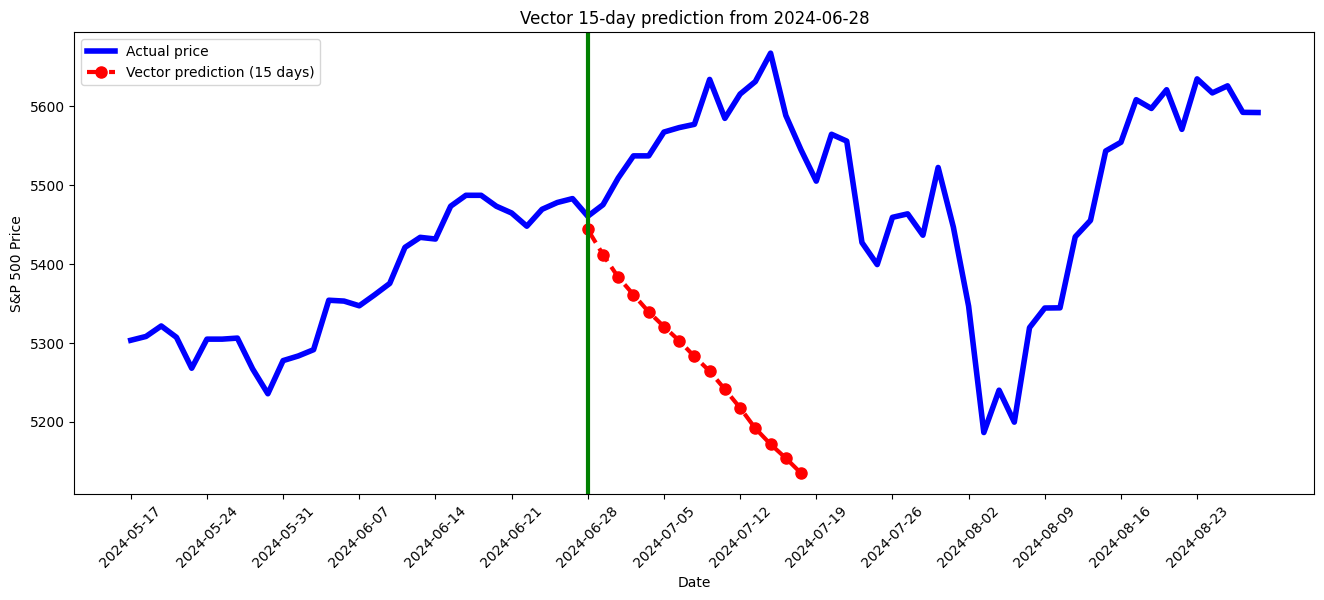

Mean Squared Error: 101261.9397
Root Mean Squared Error: 318.2168


In [33]:
plot_predictions2('2024-6-28')

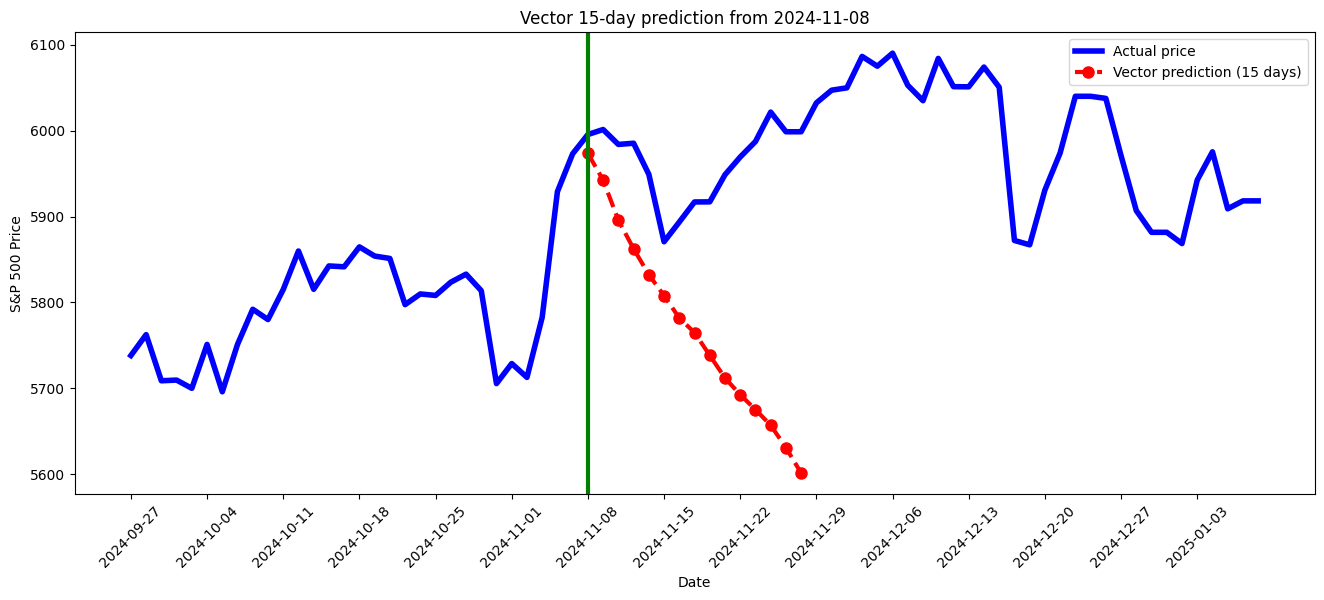

Mean Squared Error: 51240.9736
Root Mean Squared Error: 226.3647


In [34]:
plot_predictions2('2024-11-8')